In [1]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})

import csv
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import pandas as pd

from Tarjet import *
from Phisicsparams import *
from utils import *
from MTMM import *
from tqdm import tqdm

from multiresglonet import GLOnet
from material_database import MatDatabase


In [22]:
from typing import TypeVarTuple


params = Params()
params.thickness_sup = 0.1
params.N_layers = 10

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.materials = ['Al2O3','TiO2', 'SiO2']
params.user_define = True
if params.user_define:
  params.n_min = 1.09
  params.n_max = 2.6
  params.M_discretion_n = 100
  params.M_materials = params.M_discretion_n
  params.n_database = torch.tensor(np.array([np.linspace(params.n_min,params.n_max,params.M_discretion_n)]))
else:
  pass # definirlo en otro lado
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

params.alpha_sup =  15
params.numIter = 125
params.sigma = 0.035
params.batch_size = 100
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.net = 'Res'
params.res_layers = 16                                                                             # Cantidad de bloques Residuales del bloque ResNet
params.res_dim = 256                                                                               # Cantidad de neuronas en la capa de entrada al bloque ResNet
params.noise_dim = 26                                                                              # Dimension de la Capa de entrada
params.lr = 0.05                                                                                   # Tasa de aprendizaje del optimizador Adam (learning rate)
params.beta1 = 0.9                                                                                 # Coeficiente de decaimiento para el momento del primer orden del optimizador Adam
params.beta2 = 0.99                                                                                # Coeficiente de decaimiento para el momento del segundo orden del optimizador Adam
params.weight_decay = 0.001                                                                        # Termino de decaimiento del peso para regularizar los pesos del generador durante la optimizacion
params.step_size = 40000                                                                           # Numero de epicas despues de las cuales se reduce la tasa de aprendizaje
params.gamma = 0.5                                                                                 # El factor de reduccion para la tasa de aprendizaje. Despues de cada step_size epocas, la tasa de aprendizaje se multiplica por gamma


In [23]:
params.condiciones = 2
physicsparams = PhysicsParams(params.condiciones, user_define=True)

n_interna = 1.2

physicsparams.n_bot_1 = n_interna
physicsparams.n_top_1 = 1
physicsparams.k_1 = 370
physicsparams.k_values.append(physicsparams.k_1)
physicsparams.theta_1 = 0
physicsparams.lambda_min_1 = 380
physicsparams.lambda_max_1 = 750
physicsparams.pol_1 = "TE"

physicsparams.n_bot_2 = 1
physicsparams.n_top_2 = n_interna
physicsparams.k_2 = 190
physicsparams.k_values.append(physicsparams.k_2)
physicsparams.theta_2 = 45
physicsparams.lambda_min_2 = 380
physicsparams.lambda_max_2 = 570
physicsparams.pol_2 = "TE"

physicsparams.generate_physics_params()
# physicsparams.view_attributes()

tarjet = Tarjet(params.condiciones, physicsparams.k_values, params.user_define)
tarjet.configure_targets()



In [24]:
if not params.user_define:
    params.matdatabase =  MatDatabase(params.materials)
    params.n_database = params.matdatabase.interp_wv(2 * math.pi/physicsparams.ks, params.materials, True)
    params.M_materials =  params.n_database.size(0)

In [25]:

tarjet.tarjets["tarjet_1"].view(-1)[190:] = 1

tarjet.tarjets["tarjet_2"].view(-1)[115:] = 1



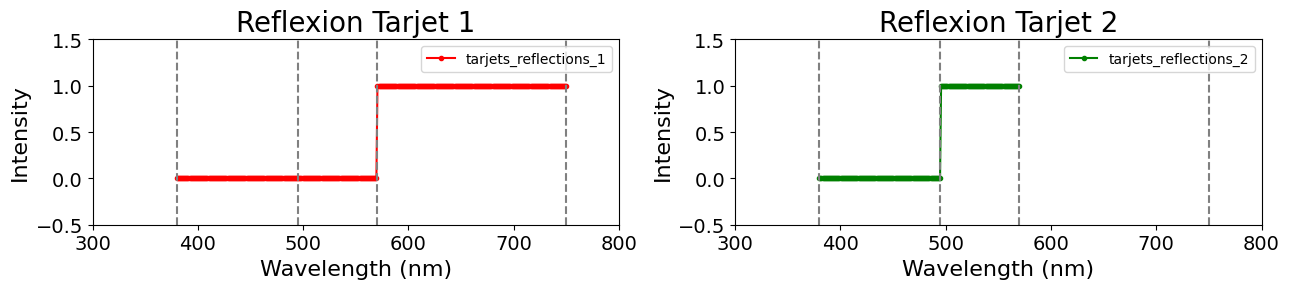

In [26]:
# Subplots para Reflexiones
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

for i, ax in enumerate(axs):
    if i == 0:
        ax.plot(2 * math.pi / physicsparams.k_1 * 1000, tarjet.tarjets["tarjet_1"].view(-1), ".-", color="red", label="tarjets_reflections_1")
        ax.set_title("Reflexion Tarjet 1", fontsize=20)
    elif i == 1:
        ax.plot(2 * math.pi / physicsparams.k_2 * 1000, tarjet.tarjets["tarjet_2"].view(-1), ".-", color="green", label="tarjets_reflections_2")
        ax.set_title("Reflexion Tarjet 2", fontsize=20)

    ax.set_xlabel("Wavelength (nm)", fontsize=16)
    ax.set_ylabel("Intensity", fontsize=16)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Agregar líneas verticales punteadas
    for line_pos in vertical_lines:
        ax.axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de reflexiones
plt.show()


In [29]:

thicknesses_list = []
ref_idx_list = []

figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

histogram_dir = "Histogramas"
os.makedirs(histogram_dir, exist_ok=True)
    
Loss_dir =  "Losses"
if not os.path.exists(Loss_dir):
    os.makedirs(Loss_dir)

Error = []
Angles = []

xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]


n_interna = 1.0



for seed in range(1000):                                                
  params.seed = seed
  params.sigma = np.random.uniform(0.025, 0.05)
  
  
  physicsparams.theta_1 = seed * 85 / 1000
  print("Angulo theta_1 : " ,physicsparams.theta_1)
  Angles.append(physicsparams.theta_1)

  physicsparams.n_bot_1 = n_interna
  physicsparams.n_top_1 = 1
  physicsparams.k_1 = 370
  physicsparams.k_values.append(physicsparams.k_1)
  physicsparams.lambda_min_1 = 380
  physicsparams.lambda_max_1 = 750
  physicsparams.pol_1 = "TE"
  
  physicsparams.n_bot_2 = 1
  physicsparams.n_top_2 = n_interna
  physicsparams.k_2 = 190
  physicsparams.k_values.append(physicsparams.k_2)
  physicsparams.theta_2 = 45
  physicsparams.lambda_min_2 = 380
  physicsparams.lambda_max_2 = 570
  physicsparams.pol_2 = "TE"
  
  physicsparams.generate_physics_params()

  print("Sigma: ", params.sigma)
  torch.manual_seed(seed)
  glonet = GLOnet(params, physicsparams, tarjet)
  glonet.train()
  
  plt.figure(figsize = (20, 5))
  plt.subplot(131)
  plt.plot(glonet.loss_training)
  plt.ylabel('Loss', fontsize=18)
  plt.xlabel('Iterations', fontsize=18)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  
  plt.savefig(f"{Loss_dir}/Loss_seed_{seed}.png", bbox_inches='tight')
  plt.close()
  
  print(f"iteration{seed + 1 }")

  with torch.no_grad():
      params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 50)
      params.theta_test = torch.linspace(0, math.pi/2.25, 50)
      (thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector=params.k_test, inc_angles=params.theta_test, grayscale=True)
      # Optimizacion
      
      reflex = MTMM_solver(params.condiciones, thicknesses, ref_index, physicsparams)
      FoM_reflex_total = sum(torch.pow(reflex[f'reflexion_{i}'] - tarjet.tarjets[f'tarjet_{i}'], 2).mean(dim=[1, 2, 3]) for i in range(1, 3))
      _, indices = torch.sort(FoM_reflex_total)
      opt_idx = indices[0]
      Error.append(FoM_reflex_total[opt_idx])
      

      # Visualización del FoM total
      
      plt.figure(figsize=(10, 2))
      plt.subplot(131)
      plt.hist(FoM_reflex_total.cpu().detach().numpy(), alpha=0.5)
      plt.xlabel(f"FoM (n' = {n_interna})", fontsize=18)
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      plt.savefig(f"{histogram_dir}/histograma_seed_{seed}.png", bbox_inches='tight')
      plt.close()
      
      # Encontrar el índice óptimo

      optimal_thicknesses = thicknesses[opt_idx]
      optimal_ref_idx = ref_index[opt_idx]
      
      thicknesses_list.append(optimal_thicknesses.view(-1).cpu().numpy().tolist())
      ref_idx_list.append(optimal_ref_idx.view(-1).cpu().numpy().tolist())

          
 
  fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
  fig.subplots_adjust(wspace=0.4)
  
  # Definir optimal_reflections
  optimal_reflections = {}
  
  for i in range(1, 3):  # Solo 1 y 2
      reflex_key = f'reflexion_{i}'
      optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
      
      # Gráfico de reflexión óptima
      axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                    optimal_reflections[f'reflexion_{i}'][:, 0, 0].detach().numpy(),
                    "-", color="violet", label="Optimal Reflexion")
  
      # Gráfico de reflexión de tarjeta
      tarjet_color = "red" if i == 1 else "green"
      axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                    tarjet.tarjets[f"tarjet_{i}"].view(-1),
                    ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)
  
      axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
      axs[i-1].set_ylabel("Reflection", fontsize=16)
      axs[i-1].legend(fontsize=10)
      axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
      axs[i-1].tick_params(axis='both', which='major', labelsize=14)
      axs[i-1].set_xlim(xlim)
      axs[i-1].set_ylim(ylim)
  
      # Agregar líneas verticales punteadas para reflexiones
      for line_pos in vertical_lines:
          axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')
          
  fig.savefig(os.path.join(figures_dir, f"reflexion_seed_{seed}.png"))
  plt.close(fig)

with open('optimal_thicknesses.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(thicknesses_list)

# Archivo CSV para los índices de refracción
with open('optimal_ref_idx.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(ref_idx_list)




Angulo theta_1 :  0.0
Sigma:  0.048446940372515415


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration1
Angulo theta_1 :  0.085
Sigma:  0.03546144984422847


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration2
Angulo theta_1 :  0.17
Sigma:  0.02933114286609996


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration3
Angulo theta_1 :  0.255
Sigma:  0.04664195198014188


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration4
Angulo theta_1 :  0.34
Sigma:  0.03497148560135636


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration5
Angulo theta_1 :  0.425
Sigma:  0.04593486716473519


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration6
Angulo theta_1 :  0.51
Sigma:  0.03746353718907063


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration7
Angulo theta_1 :  0.595
Sigma:  0.03911065484926101


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration8
Angulo theta_1 :  0.68
Sigma:  0.03856218723964963


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration9
Angulo theta_1 :  0.765
Sigma:  0.04449635258156498


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration10
Angulo theta_1 :  0.85
Sigma:  0.028763446195112383


100%|██████████| 125/125 [01:45<00:00,  1.18it/s]


iteration11
Angulo theta_1 :  0.935
Sigma:  0.040057431765108266


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration12
Angulo theta_1 :  1.02
Sigma:  0.029516290879817463


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration13
Angulo theta_1 :  1.105
Sigma:  0.038579624145568384


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration14
Angulo theta_1 :  1.19
Sigma:  0.03534712690876074


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration15
Angulo theta_1 :  1.275
Sigma:  0.03865179412220132


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration16
Angulo theta_1 :  1.36
Sigma:  0.0479170654908575


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration17
Angulo theta_1 :  1.445
Sigma:  0.028418225304987287


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration18
Angulo theta_1 :  1.53
Sigma:  0.030555364253329814


100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


iteration19
Angulo theta_1 :  1.615
Sigma:  0.0479345989733154


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


iteration20
Angulo theta_1 :  1.7
Sigma:  0.03156746610235103


100%|██████████| 125/125 [01:43<00:00,  1.21it/s]


iteration21
Angulo theta_1 :  1.785
Sigma:  0.042324531982177456


100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


iteration22
Angulo theta_1 :  1.87
Sigma:  0.029856397791961524


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration23
Angulo theta_1 :  1.955
Sigma:  0.04512782169537688


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration24
Angulo theta_1 :  2.04
Sigma:  0.026248245641545504


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration25
Angulo theta_1 :  2.125
Sigma:  0.038923385776238426


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration26
Angulo theta_1 :  2.21
Sigma:  0.04258235032003878


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration27
Angulo theta_1 :  2.295
Sigma:  0.04591089574426804


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration28
Angulo theta_1 :  2.38
Sigma:  0.031633048095186994


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration29
Angulo theta_1 :  2.465
Sigma:  0.0349946396707526


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration30
Angulo theta_1 :  2.55
Sigma:  0.04220496160923297


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration31
Angulo theta_1 :  2.635
Sigma:  0.038384860516723227


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration32
Angulo theta_1 :  2.72
Sigma:  0.030784998928660767


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration33
Angulo theta_1 :  2.805
Sigma:  0.038521779460076046


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration34
Angulo theta_1 :  2.89
Sigma:  0.03818016269243289


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration35
Angulo theta_1 :  2.975
Sigma:  0.041785662922655745


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration36
Angulo theta_1 :  3.06
Sigma:  0.04581327779010888


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration37
Angulo theta_1 :  3.145
Sigma:  0.04796396866281239


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration38
Angulo theta_1 :  3.23
Sigma:  0.0352002064222645


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration39
Angulo theta_1 :  3.315
Sigma:  0.04007147750758455


100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


iteration40
Angulo theta_1 :  3.4
Sigma:  0.02804266235896736


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration41
Angulo theta_1 :  3.485
Sigma:  0.04876615053236394


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration42
Angulo theta_1 :  3.57
Sigma:  0.040209859394542836


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration43
Angulo theta_1 :  3.655
Sigma:  0.026646444706569804


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration44
Angulo theta_1 :  3.74
Sigma:  0.027140041634648383


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration45
Angulo theta_1 :  3.825
Sigma:  0.03573761897663502


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration46
Angulo theta_1 :  3.91
Sigma:  0.027002075281186467


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration47
Angulo theta_1 :  3.995
Sigma:  0.03914787082224251


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration48
Angulo theta_1 :  4.08
Sigma:  0.04304692128269168


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration49
Angulo theta_1 :  4.165
Sigma:  0.04420626062337661


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration50
Angulo theta_1 :  4.25
Sigma:  0.04352896805335888


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration51
Angulo theta_1 :  4.335
Sigma:  0.036979534574476884


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration52
Angulo theta_1 :  4.42
Sigma:  0.03204465386740894


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration53
Angulo theta_1 :  4.505
Sigma:  0.03104367906106059


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration54
Angulo theta_1 :  4.59
Sigma:  0.03236990643455595


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration55
Angulo theta_1 :  4.675
Sigma:  0.03176395920647919


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration56
Angulo theta_1 :  4.76
Sigma:  0.04779391272434574


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration57
Angulo theta_1 :  4.845
Sigma:  0.03623219885339714


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration58
Angulo theta_1 :  4.93
Sigma:  0.03633287296649761


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration59
Angulo theta_1 :  5.015
Sigma:  0.049862330763244346


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration60
Angulo theta_1 :  5.1
Sigma:  0.04551849015604846


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


iteration61
Angulo theta_1 :  5.185
Sigma:  0.04425367104730726


100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


iteration62
Angulo theta_1 :  5.27
Sigma:  0.02502513478212591


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration63
Angulo theta_1 :  5.355
Sigma:  0.03101388151163055


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration64
Angulo theta_1 :  5.44
Sigma:  0.038869673899218984


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration65
Angulo theta_1 :  5.525
Sigma:  0.047818166344406915


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration66
Angulo theta_1 :  5.61
Sigma:  0.04324866822857564


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration67
Angulo theta_1 :  5.695
Sigma:  0.04410634222338481


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration68
Angulo theta_1 :  5.78
Sigma:  0.02756214697072544


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration69
Angulo theta_1 :  5.865
Sigma:  0.04484160806222609


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration70
Angulo theta_1 :  5.95
Sigma:  0.03864299259095608


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration71
Angulo theta_1 :  6.035
Sigma:  0.04802778987397444


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration72
Angulo theta_1 :  6.12
Sigma:  0.02969225937368673


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration73
Angulo theta_1 :  6.205
Sigma:  0.040590997939368524


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration74
Angulo theta_1 :  6.29
Sigma:  0.04020597131961277


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration75
Angulo theta_1 :  6.375
Sigma:  0.02947650571549247


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration76
Angulo theta_1 :  6.46
Sigma:  0.035342610947247936


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration77
Angulo theta_1 :  6.545
Sigma:  0.04268092167833441


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration78
Angulo theta_1 :  6.63
Sigma:  0.0416149996395746


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration79
Angulo theta_1 :  6.715
Sigma:  0.030745811486570955


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration80
Angulo theta_1 :  6.8
Sigma:  0.042582567996436935


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration81
Angulo theta_1 :  6.885
Sigma:  0.02669407600382397


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration82
Angulo theta_1 :  6.97
Sigma:  0.04388391705115371


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration83
Angulo theta_1 :  7.055
Sigma:  0.02614664553592895


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration84
Angulo theta_1 :  7.14
Sigma:  0.04026364261754408


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration85
Angulo theta_1 :  7.225
Sigma:  0.04449930823870033


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


iteration86
Angulo theta_1 :  7.31
Sigma:  0.03520641380874985


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration87
Angulo theta_1 :  7.395
Sigma:  0.046038727712471174


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration88
Angulo theta_1 :  7.48
Sigma:  0.02907213160668333


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration89
Angulo theta_1 :  7.565
Sigma:  0.025368294261095582


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration90
Angulo theta_1 :  7.65
Sigma:  0.04737930889377464


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration91
Angulo theta_1 :  7.735
Sigma:  0.041403548539448304


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration92
Angulo theta_1 :  7.82
Sigma:  0.041930289519773775


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration93
Angulo theta_1 :  7.905
Sigma:  0.030055527877024937


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration94
Angulo theta_1 :  7.99
Sigma:  0.027294265904457063


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration95
Angulo theta_1 :  8.075
Sigma:  0.027834116108576255


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration96
Angulo theta_1 :  8.16
Sigma:  0.034201890647889595


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration97
Angulo theta_1 :  8.245
Sigma:  0.038888401502265295


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration98
Angulo theta_1 :  8.33
Sigma:  0.03351224121817976


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration99
Angulo theta_1 :  8.415
Sigma:  0.04634395814048978


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration100
Angulo theta_1 :  8.5
Sigma:  0.031238960531480453


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration101
Angulo theta_1 :  8.585
Sigma:  0.03456005215048544


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration102
Angulo theta_1 :  8.67
Sigma:  0.027441874351381908


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration103
Angulo theta_1 :  8.755
Sigma:  0.030532648098295534


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration104
Angulo theta_1 :  8.84
Sigma:  0.04724633614007067


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration105
Angulo theta_1 :  8.925
Sigma:  0.03293813385948373


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration106
Angulo theta_1 :  9.01
Sigma:  0.03330963718347915


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration107
Angulo theta_1 :  9.095
Sigma:  0.04920231602113953


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration108
Angulo theta_1 :  9.18
Sigma:  0.027507269309111317


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration109
Angulo theta_1 :  9.265
Sigma:  0.02600953488055668


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration110
Angulo theta_1 :  9.35
Sigma:  0.029794990142750333


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration111
Angulo theta_1 :  9.435
Sigma:  0.031994746625012366


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration112
Angulo theta_1 :  9.52
Sigma:  0.026894476290942736


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration113
Angulo theta_1 :  9.605
Sigma:  0.028133727070202466


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration114
Angulo theta_1 :  9.69
Sigma:  0.0399214254453214


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration115
Angulo theta_1 :  9.775
Sigma:  0.02632680363175214


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration116
Angulo theta_1 :  9.86
Sigma:  0.046079283463170334


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration117
Angulo theta_1 :  9.945
Sigma:  0.028366136235765685


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration118
Angulo theta_1 :  10.03
Sigma:  0.038456457643992505


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration119
Angulo theta_1 :  10.115
Sigma:  0.027416196046679102


100%|██████████| 125/125 [01:51<00:00,  1.12it/s]


iteration120
Angulo theta_1 :  10.2
Sigma:  0.043044948871965055


100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


iteration121
Angulo theta_1 :  10.285
Sigma:  0.03414315340341844


100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


iteration122
Angulo theta_1 :  10.37
Sigma:  0.041825810456645865


100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


iteration123
Angulo theta_1 :  10.455
Sigma:  0.04122912672817045


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration124
Angulo theta_1 :  10.54
Sigma:  0.027804705659617752


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration125
Angulo theta_1 :  10.625
Sigma:  0.03918302245494849


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration126
Angulo theta_1 :  10.71
Sigma:  0.03422470228846893


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration127
Angulo theta_1 :  10.795
Sigma:  0.03782086106868885


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration128
Angulo theta_1 :  10.88
Sigma:  0.049974513568295506


100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


iteration129
Angulo theta_1 :  10.965
Sigma:  0.046586347406512865


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration130
Angulo theta_1 :  11.05
Sigma:  0.04272927310561963


100%|██████████| 125/125 [01:12<00:00,  1.74it/s]


iteration131
Angulo theta_1 :  11.135
Sigma:  0.04060939975202106


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration132
Angulo theta_1 :  11.22
Sigma:  0.0340635202572573


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration133
Angulo theta_1 :  11.305
Sigma:  0.02620932834014074


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration134
Angulo theta_1 :  11.39
Sigma:  0.04672998783775666


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


iteration135
Angulo theta_1 :  11.475
Sigma:  0.03585306807147317


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration136
Angulo theta_1 :  11.56
Sigma:  0.040235758597254444


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration137
Angulo theta_1 :  11.645
Sigma:  0.03032515686398298


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration138
Angulo theta_1 :  11.73
Sigma:  0.026273816841730514


100%|██████████| 125/125 [01:16<00:00,  1.64it/s]


iteration139
Angulo theta_1 :  11.815
Sigma:  0.04331398728649231


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration140
Angulo theta_1 :  11.9
Sigma:  0.045601781510637235


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration141
Angulo theta_1 :  11.985
Sigma:  0.04408309954896496


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration142
Angulo theta_1 :  12.07
Sigma:  0.036342352751393435


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration143
Angulo theta_1 :  12.155
Sigma:  0.03477758057850598


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration144
Angulo theta_1 :  12.24
Sigma:  0.03800296384351568


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration145
Angulo theta_1 :  12.325
Sigma:  0.03236672532999398


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration146
Angulo theta_1 :  12.41
Sigma:  0.03894530948887584


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration147
Angulo theta_1 :  12.495
Sigma:  0.049131903125117046


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration148
Angulo theta_1 :  12.58
Sigma:  0.029829300067590964


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration149
Angulo theta_1 :  12.665
Sigma:  0.049221621676415334


100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


iteration150
Angulo theta_1 :  12.75
Sigma:  0.03461989726984287


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration151
Angulo theta_1 :  12.835
Sigma:  0.048350470550446174


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration152
Angulo theta_1 :  12.92
Sigma:  0.03033883402342613


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration153
Angulo theta_1 :  13.005
Sigma:  0.03163311965617228


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration154
Angulo theta_1 :  13.09
Sigma:  0.03407962846998591


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration155
Angulo theta_1 :  13.175
Sigma:  0.027637137750815874


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration156
Angulo theta_1 :  13.26
Sigma:  0.04424183391628675


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration157
Angulo theta_1 :  13.345
Sigma:  0.040938881422414544


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration158
Angulo theta_1 :  13.43
Sigma:  0.033995911716143745


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration159
Angulo theta_1 :  13.515
Sigma:  0.04147943924724192


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration160
Angulo theta_1 :  13.6
Sigma:  0.04494717852808309


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration161
Angulo theta_1 :  13.685
Sigma:  0.03170730251697283


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration162
Angulo theta_1 :  13.77
Sigma:  0.046874154520858885


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration163
Angulo theta_1 :  13.855
Sigma:  0.029482679061337315


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration164
Angulo theta_1 :  13.94
Sigma:  0.034979762378975654


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration165
Angulo theta_1 :  14.025
Sigma:  0.03133206863604762


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration166
Angulo theta_1 :  14.11
Sigma:  0.04217655134132184


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration167
Angulo theta_1 :  14.195
Sigma:  0.029244377724043834


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration168
Angulo theta_1 :  14.28
Sigma:  0.025678831019474224


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration169
Angulo theta_1 :  14.365
Sigma:  0.03583222105888828


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration170
Angulo theta_1 :  14.45
Sigma:  0.047133939166982664


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration171
Angulo theta_1 :  14.535
Sigma:  0.026767204394547457


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration172
Angulo theta_1 :  14.62
Sigma:  0.034351093079943204


100%|██████████| 125/125 [01:07<00:00,  1.87it/s]


iteration173
Angulo theta_1 :  14.705
Sigma:  0.046221606207091856


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration174
Angulo theta_1 :  14.79
Sigma:  0.03709229097440117


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration175
Angulo theta_1 :  14.875
Sigma:  0.048288613478400855


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration176
Angulo theta_1 :  14.96
Sigma:  0.029204703713391095


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration177
Angulo theta_1 :  15.045
Sigma:  0.04879272230414842


100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


iteration178
Angulo theta_1 :  15.13
Sigma:  0.03733178360560458


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration179
Angulo theta_1 :  15.215
Sigma:  0.043236604963946025


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration180
Angulo theta_1 :  15.3
Sigma:  0.03302061776674415


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration181
Angulo theta_1 :  15.385
Sigma:  0.04129972123106794


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration182
Angulo theta_1 :  15.47
Sigma:  0.03273695339551198


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration183
Angulo theta_1 :  15.555
Sigma:  0.04723260829085862


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration184
Angulo theta_1 :  15.64
Sigma:  0.036464892786803774


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration185
Angulo theta_1 :  15.725
Sigma:  0.03988994311298488


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration186
Angulo theta_1 :  15.81
Sigma:  0.049058785084088105


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration187
Angulo theta_1 :  15.895
Sigma:  0.045828142994442024


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration188
Angulo theta_1 :  15.98
Sigma:  0.04721432091888227


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration189
Angulo theta_1 :  16.065
Sigma:  0.049018891832290336


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration190
Angulo theta_1 :  16.15
Sigma:  0.03851589931202433


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration191
Angulo theta_1 :  16.235
Sigma:  0.03454341508131985


100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


iteration192
Angulo theta_1 :  16.32
Sigma:  0.030192451886576353


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


iteration193
Angulo theta_1 :  16.405
Sigma:  0.04371567489873031


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration194
Angulo theta_1 :  16.49
Sigma:  0.04110063175641657


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration195
Angulo theta_1 :  16.575
Sigma:  0.03984979704697925


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration196
Angulo theta_1 :  16.66
Sigma:  0.04065549139638723


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration197
Angulo theta_1 :  16.745
Sigma:  0.03476548962607511


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration198
Angulo theta_1 :  16.83
Sigma:  0.03368642588792801


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration199
Angulo theta_1 :  16.915
Sigma:  0.04353275367726736


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


iteration200
Angulo theta_1 :  17.0
Sigma:  0.027117414964066763


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration201
Angulo theta_1 :  17.085
Sigma:  0.03955299585845638


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration202
Angulo theta_1 :  17.17
Sigma:  0.030188852721313303


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration203
Angulo theta_1 :  17.255
Sigma:  0.03809719079146745


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration204
Angulo theta_1 :  17.34
Sigma:  0.049079755504989914


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration205
Angulo theta_1 :  17.425
Sigma:  0.036035358976805494


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration206
Angulo theta_1 :  17.51
Sigma:  0.04476607850845635


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration207
Angulo theta_1 :  17.595
Sigma:  0.03627954195131183


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration208
Angulo theta_1 :  17.68
Sigma:  0.027559990409698705


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration209
Angulo theta_1 :  17.765
Sigma:  0.025962185108626634


100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


iteration210
Angulo theta_1 :  17.85
Sigma:  0.026888529032163447


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration211
Angulo theta_1 :  17.935
Sigma:  0.03045296409385786


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration212
Angulo theta_1 :  18.02
Sigma:  0.03198003367401642


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration213
Angulo theta_1 :  18.105
Sigma:  0.028426193981708887


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration214
Angulo theta_1 :  18.19
Sigma:  0.03315830515134521


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration215
Angulo theta_1 :  18.275
Sigma:  0.02808104323083992


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration216
Angulo theta_1 :  18.36
Sigma:  0.04598533776057144


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration217
Angulo theta_1 :  18.445
Sigma:  0.03725342928202192


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration218
Angulo theta_1 :  18.53
Sigma:  0.03575025664355098


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration219
Angulo theta_1 :  18.615
Sigma:  0.029044493887109835


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration220
Angulo theta_1 :  18.7
Sigma:  0.043979365452373693


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration221
Angulo theta_1 :  18.785
Sigma:  0.02701760441244926


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration222
Angulo theta_1 :  18.87
Sigma:  0.03180490903422363


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration223
Angulo theta_1 :  18.955
Sigma:  0.029550520131390787


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration224
Angulo theta_1 :  19.04
Sigma:  0.03080204561561919


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration225
Angulo theta_1 :  19.125
Sigma:  0.03497322435172001


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration226
Angulo theta_1 :  19.21
Sigma:  0.03994827131887083


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration227
Angulo theta_1 :  19.295
Sigma:  0.03981856714751767


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration228
Angulo theta_1 :  19.38
Sigma:  0.04447749325059179


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration229
Angulo theta_1 :  19.465
Sigma:  0.04656394506019422


100%|██████████| 125/125 [01:15<00:00,  1.67it/s]


iteration230
Angulo theta_1 :  19.55
Sigma:  0.0340196956867119


100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


iteration231
Angulo theta_1 :  19.635
Sigma:  0.037794118029051665


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration232
Angulo theta_1 :  19.72
Sigma:  0.04572808895979243


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration233
Angulo theta_1 :  19.805
Sigma:  0.03297293670937591


100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


iteration234
Angulo theta_1 :  19.89
Sigma:  0.04378326360513525


100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


iteration235
Angulo theta_1 :  19.975
Sigma:  0.04318877240199411


100%|██████████| 125/125 [01:12<00:00,  1.71it/s]


iteration236
Angulo theta_1 :  20.06
Sigma:  0.036223390122212526


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration237
Angulo theta_1 :  20.145
Sigma:  0.04999175779153332


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration238
Angulo theta_1 :  20.23
Sigma:  0.03117983558685259


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration239
Angulo theta_1 :  20.315
Sigma:  0.046598737887103184


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration240
Angulo theta_1 :  20.4
Sigma:  0.03052958160096787


100%|██████████| 125/125 [01:12<00:00,  1.71it/s]


iteration241
Angulo theta_1 :  20.485
Sigma:  0.048701693516672334


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration242
Angulo theta_1 :  20.57
Sigma:  0.026957572939792923


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration243
Angulo theta_1 :  20.655
Sigma:  0.029262034993998702


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration244
Angulo theta_1 :  20.74
Sigma:  0.02712334985428317


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration245
Angulo theta_1 :  20.825
Sigma:  0.036634180153644974


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration246
Angulo theta_1 :  20.91
Sigma:  0.03450640292786228


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration247
Angulo theta_1 :  20.995
Sigma:  0.04467183351839942


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration248
Angulo theta_1 :  21.08
Sigma:  0.03232848101916912


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration249
Angulo theta_1 :  21.165
Sigma:  0.028286161955682478


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration250
Angulo theta_1 :  21.25
Sigma:  0.02762551969015908


100%|██████████| 125/125 [01:12<00:00,  1.74it/s]


iteration251
Angulo theta_1 :  21.335
Sigma:  0.04081669161309873


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


iteration252
Angulo theta_1 :  21.42
Sigma:  0.03021302647031509


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration253
Angulo theta_1 :  21.505
Sigma:  0.049955330832476885


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration254
Angulo theta_1 :  21.59
Sigma:  0.028590956216421052


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration255
Angulo theta_1 :  21.675
Sigma:  0.02888852289811169


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration256
Angulo theta_1 :  21.76
Sigma:  0.029567151503897104


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


iteration257
Angulo theta_1 :  21.845
Sigma:  0.04841004277228579


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration258
Angulo theta_1 :  21.93
Sigma:  0.028285498796214167


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration259
Angulo theta_1 :  22.015
Sigma:  0.035056994397853265


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration260
Angulo theta_1 :  22.1
Sigma:  0.04713076133701897


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration261
Angulo theta_1 :  22.185
Sigma:  0.03539449904770321


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration262
Angulo theta_1 :  22.27
Sigma:  0.0405050236841125


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration263
Angulo theta_1 :  22.355
Sigma:  0.048761290077633274


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration264
Angulo theta_1 :  22.44
Sigma:  0.025714576930435606


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration265
Angulo theta_1 :  22.525
Sigma:  0.048320913731104836


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration266
Angulo theta_1 :  22.61
Sigma:  0.04636926853822485


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration267
Angulo theta_1 :  22.695
Sigma:  0.025818354782121217


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration268
Angulo theta_1 :  22.78
Sigma:  0.049589249461783745


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration269
Angulo theta_1 :  22.865
Sigma:  0.04477972192808408


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration270
Angulo theta_1 :  22.95
Sigma:  0.03165824112922194


100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


iteration271
Angulo theta_1 :  23.035
Sigma:  0.046711309670405085


100%|██████████| 125/125 [01:52<00:00,  1.11it/s]


iteration272
Angulo theta_1 :  23.12
Sigma:  0.03646956238007798


100%|██████████| 125/125 [01:44<00:00,  1.20it/s]


iteration273
Angulo theta_1 :  23.205
Sigma:  0.03229330028558004


100%|██████████| 125/125 [01:47<00:00,  1.16it/s]


iteration274
Angulo theta_1 :  23.29
Sigma:  0.030791100402210607


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


iteration275
Angulo theta_1 :  23.375
Sigma:  0.04220733378369239


100%|██████████| 125/125 [01:44<00:00,  1.20it/s]


iteration276
Angulo theta_1 :  23.46
Sigma:  0.048023454247829514


100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


iteration277
Angulo theta_1 :  23.545
Sigma:  0.03773593970864336


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration278
Angulo theta_1 :  23.63
Sigma:  0.028775914299180846


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration279
Angulo theta_1 :  23.715
Sigma:  0.03157099392718346


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration280
Angulo theta_1 :  23.8
Sigma:  0.035633196799873854


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration281
Angulo theta_1 :  23.885
Sigma:  0.04336399486480803


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration282
Angulo theta_1 :  23.97
Sigma:  0.04764960993207654


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration283
Angulo theta_1 :  24.055
Sigma:  0.039283125778869415


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration284
Angulo theta_1 :  24.14
Sigma:  0.04510937223544202


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration285
Angulo theta_1 :  24.225
Sigma:  0.046347064760965846


100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


iteration286
Angulo theta_1 :  24.31
Sigma:  0.03855023318877206


100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


iteration287
Angulo theta_1 :  24.395
Sigma:  0.0481988005251498


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration288
Angulo theta_1 :  24.48
Sigma:  0.033485299249856486


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration289
Angulo theta_1 :  24.565
Sigma:  0.02929134201657895


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration290
Angulo theta_1 :  24.65
Sigma:  0.04100346015173781


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration291
Angulo theta_1 :  24.735
Sigma:  0.03804258788658092


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration292
Angulo theta_1 :  24.82
Sigma:  0.03927041960214526


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration293
Angulo theta_1 :  24.905
Sigma:  0.04158273077168392


100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


iteration294
Angulo theta_1 :  24.99
Sigma:  0.03517550441601533


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration295
Angulo theta_1 :  25.075
Sigma:  0.04181509262948942


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration296
Angulo theta_1 :  25.16
Sigma:  0.03360712481161793


100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


iteration297
Angulo theta_1 :  25.245
Sigma:  0.031416854664895966


100%|██████████| 125/125 [01:41<00:00,  1.23it/s]


iteration298
Angulo theta_1 :  25.33
Sigma:  0.032088387995742325


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration299
Angulo theta_1 :  25.415
Sigma:  0.027581927388409404


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration300
Angulo theta_1 :  25.5
Sigma:  0.027081960220308527


100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


iteration301
Angulo theta_1 :  25.585
Sigma:  0.03764946998884108


100%|██████████| 125/125 [01:47<00:00,  1.16it/s]


iteration302
Angulo theta_1 :  25.67
Sigma:  0.04105009999128262


100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


iteration303
Angulo theta_1 :  25.755
Sigma:  0.036669642852889026


100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


iteration304
Angulo theta_1 :  25.84
Sigma:  0.047595190342041974


100%|██████████| 125/125 [02:36<00:00,  1.25s/it]


iteration305
Angulo theta_1 :  25.925
Sigma:  0.029902087446402267


100%|██████████| 125/125 [03:21<00:00,  1.62s/it]


iteration306
Angulo theta_1 :  26.01
Sigma:  0.031426807056328034


100%|██████████| 125/125 [09:51<00:00,  4.73s/it]


iteration307
Angulo theta_1 :  26.095
Sigma:  0.04443257741802373


100%|██████████| 125/125 [09:03<00:00,  4.35s/it]


iteration308
Angulo theta_1 :  26.18
Sigma:  0.04405743363962414


100%|██████████| 125/125 [05:17<00:00,  2.54s/it]


iteration309
Angulo theta_1 :  26.265
Sigma:  0.031161409701656817


100%|██████████| 125/125 [04:18<00:00,  2.07s/it]


iteration310
Angulo theta_1 :  26.35
Sigma:  0.04117584053925827


100%|██████████| 125/125 [01:41<00:00,  1.23it/s]


iteration311
Angulo theta_1 :  26.435
Sigma:  0.031537457358584924


100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


iteration312
Angulo theta_1 :  26.52
Sigma:  0.03279436834685183


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration313
Angulo theta_1 :  26.605
Sigma:  0.04535959851479308


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration314
Angulo theta_1 :  26.69
Sigma:  0.04767680477347938


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


iteration315
Angulo theta_1 :  26.775
Sigma:  0.040188540209289046


100%|██████████| 125/125 [02:08<00:00,  1.03s/it]


iteration316
Angulo theta_1 :  26.86
Sigma:  0.04651523676086024


100%|██████████| 125/125 [01:54<00:00,  1.09it/s]


iteration317
Angulo theta_1 :  26.945
Sigma:  0.04381685007100811


100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


iteration318
Angulo theta_1 :  27.03
Sigma:  0.0498617318613107


100%|██████████| 125/125 [01:18<00:00,  1.60it/s]


iteration319
Angulo theta_1 :  27.115
Sigma:  0.043391300616781564


100%|██████████| 125/125 [01:42<00:00,  1.21it/s]


iteration320
Angulo theta_1 :  27.2
Sigma:  0.040061703965507914


100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


iteration321
Angulo theta_1 :  27.285
Sigma:  0.027032954812808166


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration322
Angulo theta_1 :  27.37
Sigma:  0.04040210493944284


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration323
Angulo theta_1 :  27.455
Sigma:  0.045638321142200636


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration324
Angulo theta_1 :  27.54
Sigma:  0.0497704385355289


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration325
Angulo theta_1 :  27.625
Sigma:  0.029209386993554073


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration326
Angulo theta_1 :  27.71
Sigma:  0.028322647518798736


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration327
Angulo theta_1 :  27.795
Sigma:  0.049476995275869295


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration328
Angulo theta_1 :  27.88
Sigma:  0.04449840502277802


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration329
Angulo theta_1 :  27.965
Sigma:  0.04062642653472943


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration330
Angulo theta_1 :  28.05
Sigma:  0.026623055117967417


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration331
Angulo theta_1 :  28.135
Sigma:  0.029236776838414965


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration332
Angulo theta_1 :  28.22
Sigma:  0.0253443460405179


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration333
Angulo theta_1 :  28.305
Sigma:  0.028975348468272367


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration334
Angulo theta_1 :  28.39
Sigma:  0.02992210926603178


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration335
Angulo theta_1 :  28.475
Sigma:  0.045773852026922066


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration336
Angulo theta_1 :  28.56
Sigma:  0.0304273179747844


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration337
Angulo theta_1 :  28.645
Sigma:  0.030933034933053067


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration338
Angulo theta_1 :  28.73
Sigma:  0.04816421268935538


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration339
Angulo theta_1 :  28.815
Sigma:  0.03752065759460547


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration340
Angulo theta_1 :  28.9
Sigma:  0.04851561701670455


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration341
Angulo theta_1 :  28.985
Sigma:  0.04249612382357032


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration342
Angulo theta_1 :  29.07
Sigma:  0.03802865066591095


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration343
Angulo theta_1 :  29.155
Sigma:  0.03201566217918141


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration344
Angulo theta_1 :  29.24
Sigma:  0.03918006087175013


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration345
Angulo theta_1 :  29.325
Sigma:  0.02640247488091134


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration346
Angulo theta_1 :  29.41
Sigma:  0.03719745449846429


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration347
Angulo theta_1 :  29.495
Sigma:  0.02985156428291539


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration348
Angulo theta_1 :  29.58
Sigma:  0.04877108924437028


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration349
Angulo theta_1 :  29.665
Sigma:  0.049169424261297154


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration350
Angulo theta_1 :  29.75
Sigma:  0.044219250734285925


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration351
Angulo theta_1 :  29.835
Sigma:  0.028472396028793544


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration352
Angulo theta_1 :  29.92
Sigma:  0.02803378280602462


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration353
Angulo theta_1 :  30.005
Sigma:  0.04115040896973615


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration354
Angulo theta_1 :  30.09
Sigma:  0.025019267410480307


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration355
Angulo theta_1 :  30.175
Sigma:  0.027825717806565925


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration356
Angulo theta_1 :  30.26
Sigma:  0.028145701372934734


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration357
Angulo theta_1 :  30.345
Sigma:  0.03580167844542681


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration358
Angulo theta_1 :  30.43
Sigma:  0.03995426472137386


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration359
Angulo theta_1 :  30.515
Sigma:  0.03505637557499136


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration360
Angulo theta_1 :  30.6
Sigma:  0.04652146512377843


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration361
Angulo theta_1 :  30.685
Sigma:  0.026174859755537704


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration362
Angulo theta_1 :  30.77
Sigma:  0.04801158368882395


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration363
Angulo theta_1 :  30.855
Sigma:  0.031079053680860298


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration364
Angulo theta_1 :  30.94
Sigma:  0.039770035822952673


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration365
Angulo theta_1 :  31.025
Sigma:  0.03994823577582083


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration366
Angulo theta_1 :  31.11
Sigma:  0.03825178435958161


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration367
Angulo theta_1 :  31.195
Sigma:  0.043391597956534925


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration368
Angulo theta_1 :  31.28
Sigma:  0.03371954292148382


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration369
Angulo theta_1 :  31.365
Sigma:  0.04974662487184362


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration370
Angulo theta_1 :  31.45
Sigma:  0.033997060751754786


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration371
Angulo theta_1 :  31.535
Sigma:  0.04022539775145614


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration372
Angulo theta_1 :  31.62
Sigma:  0.02785686006870149


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration373
Angulo theta_1 :  31.705
Sigma:  0.037458061866868085


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration374
Angulo theta_1 :  31.79
Sigma:  0.029021648658863083


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration375
Angulo theta_1 :  31.875
Sigma:  0.0474013741234831


100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


iteration376
Angulo theta_1 :  31.96
Sigma:  0.03612968463297659


100%|██████████| 125/125 [01:38<00:00,  1.27it/s]


iteration377
Angulo theta_1 :  32.045
Sigma:  0.03206898677640452


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration378
Angulo theta_1 :  32.13
Sigma:  0.03198944219508053


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration379
Angulo theta_1 :  32.215
Sigma:  0.029705032696006897


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration380
Angulo theta_1 :  32.3
Sigma:  0.03467850633775574


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration381
Angulo theta_1 :  32.385
Sigma:  0.045437950421542264


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration382
Angulo theta_1 :  32.47
Sigma:  0.03247812276688512


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration383
Angulo theta_1 :  32.555
Sigma:  0.03263665531237525


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration384
Angulo theta_1 :  32.64
Sigma:  0.04370611276892875


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration385
Angulo theta_1 :  32.725
Sigma:  0.027648442979168106


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration386
Angulo theta_1 :  32.81
Sigma:  0.03660232005328187


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration387
Angulo theta_1 :  32.895
Sigma:  0.027227803649237433


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration388
Angulo theta_1 :  32.98
Sigma:  0.045074816447428855


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration389
Angulo theta_1 :  33.065
Sigma:  0.03814958843747286


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration390
Angulo theta_1 :  33.15
Sigma:  0.04372028125146528


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration391
Angulo theta_1 :  33.235
Sigma:  0.04581804532987076


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration392
Angulo theta_1 :  33.32
Sigma:  0.046921134259600664


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration393
Angulo theta_1 :  33.405
Sigma:  0.04686915597252391


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration394
Angulo theta_1 :  33.49
Sigma:  0.04577217182393009


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration395
Angulo theta_1 :  33.575
Sigma:  0.04404564788650657


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration396
Angulo theta_1 :  33.66
Sigma:  0.029472063651448


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration397
Angulo theta_1 :  33.745
Sigma:  0.043710669327147955


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration398
Angulo theta_1 :  33.83
Sigma:  0.02631853956820543


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration399
Angulo theta_1 :  33.915
Sigma:  0.04311645732589459


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration400
Angulo theta_1 :  34.0
Sigma:  0.045134214541036326


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration401
Angulo theta_1 :  34.085
Sigma:  0.04671203875659995


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration402
Angulo theta_1 :  34.17
Sigma:  0.04334421179086162


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration403
Angulo theta_1 :  34.255
Sigma:  0.04716343871705163


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration404
Angulo theta_1 :  34.34
Sigma:  0.04846294087728459


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration405
Angulo theta_1 :  34.425
Sigma:  0.041067853079832864


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration406
Angulo theta_1 :  34.51
Sigma:  0.04738553579979104


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration407
Angulo theta_1 :  34.595
Sigma:  0.04293579650930544


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration408
Angulo theta_1 :  34.68
Sigma:  0.031217371974842707


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration409
Angulo theta_1 :  34.765
Sigma:  0.04187651186934016


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration410
Angulo theta_1 :  34.85
Sigma:  0.03324286887801356


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration411
Angulo theta_1 :  34.935
Sigma:  0.03712523522663016


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration412
Angulo theta_1 :  35.02
Sigma:  0.03126139426630395


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration413
Angulo theta_1 :  35.105
Sigma:  0.0487587535108269


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration414
Angulo theta_1 :  35.19
Sigma:  0.04118074398186462


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration415
Angulo theta_1 :  35.275
Sigma:  0.04195993996806249


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration416
Angulo theta_1 :  35.36
Sigma:  0.044593590127855624


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration417
Angulo theta_1 :  35.445
Sigma:  0.04302949492055569


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration418
Angulo theta_1 :  35.53
Sigma:  0.03569606069858627


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration419
Angulo theta_1 :  35.615
Sigma:  0.037105418264665666


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration420
Angulo theta_1 :  35.7
Sigma:  0.03937047067260327


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration421
Angulo theta_1 :  35.785
Sigma:  0.03180625975368681


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration422
Angulo theta_1 :  35.87
Sigma:  0.03178021752503546


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration423
Angulo theta_1 :  35.955
Sigma:  0.037573385142861807


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration424
Angulo theta_1 :  36.04
Sigma:  0.03546701257999425


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration425
Angulo theta_1 :  36.125
Sigma:  0.03290879595905315


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration426
Angulo theta_1 :  36.21
Sigma:  0.04380024925929203


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration427
Angulo theta_1 :  36.295
Sigma:  0.04478160069997153


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration428
Angulo theta_1 :  36.38
Sigma:  0.047273101231188754


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration429
Angulo theta_1 :  36.465
Sigma:  0.03395786725452017


100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


iteration430
Angulo theta_1 :  36.55
Sigma:  0.04757909185861855


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration431
Angulo theta_1 :  36.635
Sigma:  0.04245796251820644


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration432
Angulo theta_1 :  36.72
Sigma:  0.03757312451259021


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration433
Angulo theta_1 :  36.805
Sigma:  0.029981033425602634


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration434
Angulo theta_1 :  36.89
Sigma:  0.041449708279014896


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration435
Angulo theta_1 :  36.975
Sigma:  0.03379336234242772


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration436
Angulo theta_1 :  37.06
Sigma:  0.03163800809251517


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration437
Angulo theta_1 :  37.145
Sigma:  0.0476326763479058


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration438
Angulo theta_1 :  37.23
Sigma:  0.04183260441450311


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration439
Angulo theta_1 :  37.315
Sigma:  0.03297901338511269


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration440
Angulo theta_1 :  37.4
Sigma:  0.048440242783261096


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration441
Angulo theta_1 :  37.485
Sigma:  0.04558662805813726


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration442
Angulo theta_1 :  37.57
Sigma:  0.028608656317505445


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration443
Angulo theta_1 :  37.655
Sigma:  0.03966562622638889


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration444
Angulo theta_1 :  37.74
Sigma:  0.038889190323198194


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration445
Angulo theta_1 :  37.825
Sigma:  0.03343711718418189


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration446
Angulo theta_1 :  37.91
Sigma:  0.046809299054987756


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration447
Angulo theta_1 :  37.995
Sigma:  0.04439227712185397


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration448
Angulo theta_1 :  38.08
Sigma:  0.0275640816527307


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration449
Angulo theta_1 :  38.165
Sigma:  0.03753120458188894


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration450
Angulo theta_1 :  38.25
Sigma:  0.03593432835173272


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration451
Angulo theta_1 :  38.335
Sigma:  0.03717300585798893


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration452
Angulo theta_1 :  38.42
Sigma:  0.04050227985296742


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration453
Angulo theta_1 :  38.505
Sigma:  0.0321436318545439


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration454
Angulo theta_1 :  38.59
Sigma:  0.046679923377012204


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration455
Angulo theta_1 :  38.675
Sigma:  0.029996039778933226


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration456
Angulo theta_1 :  38.76
Sigma:  0.041513194187749514


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration457
Angulo theta_1 :  38.845
Sigma:  0.047741784630261325


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration458
Angulo theta_1 :  38.93
Sigma:  0.03240909265638789


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration459
Angulo theta_1 :  39.015
Sigma:  0.048344682246997395


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration460
Angulo theta_1 :  39.1
Sigma:  0.04115426616888376


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration461
Angulo theta_1 :  39.185
Sigma:  0.02803638759857325


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration462
Angulo theta_1 :  39.27
Sigma:  0.028041410179364762


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration463
Angulo theta_1 :  39.355
Sigma:  0.038681715061326415


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration464
Angulo theta_1 :  39.44
Sigma:  0.02684697168322388


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration465
Angulo theta_1 :  39.525
Sigma:  0.03425564951865041


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration466
Angulo theta_1 :  39.61
Sigma:  0.027391742045309114


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration467
Angulo theta_1 :  39.695
Sigma:  0.04800391200217456


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration468
Angulo theta_1 :  39.78
Sigma:  0.03446452659208274


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration469
Angulo theta_1 :  39.865
Sigma:  0.040156128144503145


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration470
Angulo theta_1 :  39.95
Sigma:  0.04413682048630443


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration471
Angulo theta_1 :  40.035
Sigma:  0.042807296905726246


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration472
Angulo theta_1 :  40.12
Sigma:  0.044951680610504086


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration473
Angulo theta_1 :  40.205
Sigma:  0.02609365687833201


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration474
Angulo theta_1 :  40.29
Sigma:  0.04838352040865735


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration475
Angulo theta_1 :  40.375
Sigma:  0.027509383929307844


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration476
Angulo theta_1 :  40.46
Sigma:  0.02817250244553106


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration477
Angulo theta_1 :  40.545
Sigma:  0.04025435713386349


100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


iteration478
Angulo theta_1 :  40.63
Sigma:  0.04216006208805091


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration479
Angulo theta_1 :  40.715
Sigma:  0.0267901000390138


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration480
Angulo theta_1 :  40.8
Sigma:  0.03633568489622176


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration481
Angulo theta_1 :  40.885
Sigma:  0.04862525695428994


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration482
Angulo theta_1 :  40.97
Sigma:  0.028905221210211038


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration483
Angulo theta_1 :  41.055
Sigma:  0.04356494042669776


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration484
Angulo theta_1 :  41.14
Sigma:  0.04746527276761047


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration485
Angulo theta_1 :  41.225
Sigma:  0.0338784761695964


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration486
Angulo theta_1 :  41.31
Sigma:  0.04216559381639457


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration487
Angulo theta_1 :  41.395
Sigma:  0.03108241075819196


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration488
Angulo theta_1 :  41.48
Sigma:  0.02840236261572528


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration489
Angulo theta_1 :  41.565
Sigma:  0.030341272974196563


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration490
Angulo theta_1 :  41.65
Sigma:  0.02606352492028674


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration491
Angulo theta_1 :  41.735
Sigma:  0.03294057318489994


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration492
Angulo theta_1 :  41.82
Sigma:  0.037722414126018955


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration493
Angulo theta_1 :  41.905
Sigma:  0.03480012019370159


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration494
Angulo theta_1 :  41.99
Sigma:  0.03751515658538133


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration495
Angulo theta_1 :  42.075
Sigma:  0.03095790551053029


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration496
Angulo theta_1 :  42.16
Sigma:  0.046035193803766625


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration497
Angulo theta_1 :  42.245
Sigma:  0.041520962855032706


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration498
Angulo theta_1 :  42.33
Sigma:  0.03694108230161475


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration499
Angulo theta_1 :  42.415
Sigma:  0.03068492268901387


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration500
Angulo theta_1 :  42.5
Sigma:  0.028496161296706457


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration501
Angulo theta_1 :  42.585
Sigma:  0.043492529129629344


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration502
Angulo theta_1 :  42.67
Sigma:  0.036798001956702305


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration503
Angulo theta_1 :  42.755
Sigma:  0.0465127011599918


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration504
Angulo theta_1 :  42.84
Sigma:  0.026461815157335693


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration505
Angulo theta_1 :  42.925
Sigma:  0.025285309511956136


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration506
Angulo theta_1 :  43.01
Sigma:  0.0336212455199264


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration507
Angulo theta_1 :  43.095
Sigma:  0.026649980346118127


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration508
Angulo theta_1 :  43.18
Sigma:  0.046136519791047034


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration509
Angulo theta_1 :  43.265
Sigma:  0.03201058684186918


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration510
Angulo theta_1 :  43.35
Sigma:  0.034137672955779776


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration511
Angulo theta_1 :  43.435
Sigma:  0.04949662461996274


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration512
Angulo theta_1 :  43.52
Sigma:  0.03588640992557693


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration513
Angulo theta_1 :  43.605
Sigma:  0.03838100681512386


100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


iteration514
Angulo theta_1 :  43.69
Sigma:  0.031199303218337218


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration515
Angulo theta_1 :  43.775
Sigma:  0.039219064494909125


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration516
Angulo theta_1 :  43.86
Sigma:  0.04144212302150345


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration517
Angulo theta_1 :  43.945
Sigma:  0.03106948156965204


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration518
Angulo theta_1 :  44.03
Sigma:  0.036794078394348964


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration519
Angulo theta_1 :  44.115
Sigma:  0.03938052340354886


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration520
Angulo theta_1 :  44.2
Sigma:  0.0489128120393611


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration521
Angulo theta_1 :  44.285
Sigma:  0.03860317543533495


100%|██████████| 125/125 [01:20<00:00,  1.56it/s]


iteration522
Angulo theta_1 :  44.37
Sigma:  0.04016796114567243


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration523
Angulo theta_1 :  44.455
Sigma:  0.026158057109095016


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration524
Angulo theta_1 :  44.54
Sigma:  0.03247713582587469


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration525
Angulo theta_1 :  44.625
Sigma:  0.027330729121564715


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration526
Angulo theta_1 :  44.71
Sigma:  0.031891331595646874


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration527
Angulo theta_1 :  44.795
Sigma:  0.039206987566813574


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration528
Angulo theta_1 :  44.88
Sigma:  0.025946586351689928


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration529
Angulo theta_1 :  44.965
Sigma:  0.03934611051762438


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration530
Angulo theta_1 :  45.05
Sigma:  0.04924904432418632


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration531
Angulo theta_1 :  45.135
Sigma:  0.049677268138244385


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration532
Angulo theta_1 :  45.22
Sigma:  0.03202425167285087


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration533
Angulo theta_1 :  45.305
Sigma:  0.04503285646355287


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration534
Angulo theta_1 :  45.39
Sigma:  0.04307132284748377


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration535
Angulo theta_1 :  45.475
Sigma:  0.03568664761694168


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration536
Angulo theta_1 :  45.56
Sigma:  0.030433533995564546


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration537
Angulo theta_1 :  45.645
Sigma:  0.0334734765631195


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration538
Angulo theta_1 :  45.73
Sigma:  0.04759512674929481


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration539
Angulo theta_1 :  45.815
Sigma:  0.028898938594103817


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration540
Angulo theta_1 :  45.9
Sigma:  0.03709374839228688


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration541
Angulo theta_1 :  45.985
Sigma:  0.03496749282969359


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration542
Angulo theta_1 :  46.07
Sigma:  0.039729766194141404


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration543
Angulo theta_1 :  46.155
Sigma:  0.03318241521599243


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration544
Angulo theta_1 :  46.24
Sigma:  0.036552503935283656


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration545
Angulo theta_1 :  46.325
Sigma:  0.02824767005143906


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration546
Angulo theta_1 :  46.41
Sigma:  0.04354118734888123


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration547
Angulo theta_1 :  46.495
Sigma:  0.03708210708709858


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration548
Angulo theta_1 :  46.58
Sigma:  0.025995612833992165


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration549
Angulo theta_1 :  46.665
Sigma:  0.030779779999449183


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration550
Angulo theta_1 :  46.75
Sigma:  0.03010701840728659


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration551
Angulo theta_1 :  46.835
Sigma:  0.04638474969988119


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration552
Angulo theta_1 :  46.92
Sigma:  0.04064411477174698


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration553
Angulo theta_1 :  47.005
Sigma:  0.03786306605367613


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration554
Angulo theta_1 :  47.09
Sigma:  0.02701758780063492


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration555
Angulo theta_1 :  47.175
Sigma:  0.03025942136871093


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration556
Angulo theta_1 :  47.26
Sigma:  0.025144423968780843


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration557
Angulo theta_1 :  47.345
Sigma:  0.03699934652507839


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration558
Angulo theta_1 :  47.43
Sigma:  0.0259436838103


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration559
Angulo theta_1 :  47.515
Sigma:  0.03318787513011745


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration560
Angulo theta_1 :  47.6
Sigma:  0.04272254193291234


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration561
Angulo theta_1 :  47.685
Sigma:  0.04823693310564514


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration562
Angulo theta_1 :  47.77
Sigma:  0.030188915463809182


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration563
Angulo theta_1 :  47.855
Sigma:  0.048581391039291676


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration564
Angulo theta_1 :  47.94
Sigma:  0.02523631710784198


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration565
Angulo theta_1 :  48.025
Sigma:  0.043111061519627784


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration566
Angulo theta_1 :  48.11
Sigma:  0.03151906710400092


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration567
Angulo theta_1 :  48.195
Sigma:  0.044936586362146536


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration568
Angulo theta_1 :  48.28
Sigma:  0.03926507098835036


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration569
Angulo theta_1 :  48.365
Sigma:  0.049839160663038326


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration570
Angulo theta_1 :  48.45
Sigma:  0.02830959851976986


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration571
Angulo theta_1 :  48.535
Sigma:  0.03475831678647558


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration572
Angulo theta_1 :  48.62
Sigma:  0.04652728733881523


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration573
Angulo theta_1 :  48.705
Sigma:  0.02797621264198492


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration574
Angulo theta_1 :  48.79
Sigma:  0.04920838576587491


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration575
Angulo theta_1 :  48.875
Sigma:  0.03835012586108371


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration576
Angulo theta_1 :  48.96
Sigma:  0.04548204895584604


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration577
Angulo theta_1 :  49.045
Sigma:  0.02625622335484873


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration578
Angulo theta_1 :  49.13
Sigma:  0.03517910245652814


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration579
Angulo theta_1 :  49.215
Sigma:  0.027218835398005903


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration580
Angulo theta_1 :  49.3
Sigma:  0.02508825877196751


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration581
Angulo theta_1 :  49.385
Sigma:  0.02638544397017407


100%|██████████| 125/125 [01:02<00:00,  1.98it/s]


iteration582
Angulo theta_1 :  49.47
Sigma:  0.03741096520178768


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration583
Angulo theta_1 :  49.555
Sigma:  0.047806092577187834


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration584
Angulo theta_1 :  49.64
Sigma:  0.04794524168009565


100%|██████████| 125/125 [01:02<00:00,  1.98it/s]


iteration585
Angulo theta_1 :  49.725
Sigma:  0.04798003727314576


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration586
Angulo theta_1 :  49.81
Sigma:  0.027795088943705658


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration587
Angulo theta_1 :  49.895
Sigma:  0.03607441013731988


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration588
Angulo theta_1 :  49.98
Sigma:  0.041611648230955645


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration589
Angulo theta_1 :  50.065
Sigma:  0.04431276759878904


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration590
Angulo theta_1 :  50.15
Sigma:  0.0446628133748034


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration591
Angulo theta_1 :  50.235
Sigma:  0.04125973732255156


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration592
Angulo theta_1 :  50.32
Sigma:  0.04953774885641481


100%|██████████| 125/125 [01:02<00:00,  1.98it/s]


iteration593
Angulo theta_1 :  50.405
Sigma:  0.027749840244909674


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration594
Angulo theta_1 :  50.49
Sigma:  0.03679700317696388


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration595
Angulo theta_1 :  50.575
Sigma:  0.04218161723034


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration596
Angulo theta_1 :  50.66
Sigma:  0.04762524760211039


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration597
Angulo theta_1 :  50.745
Sigma:  0.029853153110982026


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration598
Angulo theta_1 :  50.83
Sigma:  0.03784109139007355


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration599
Angulo theta_1 :  50.915
Sigma:  0.04330847711830577


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration600
Angulo theta_1 :  51.0
Sigma:  0.040968499822318635


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration601
Angulo theta_1 :  51.085
Sigma:  0.04154355023337604


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration602
Angulo theta_1 :  51.17
Sigma:  0.040283042395880715


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration603
Angulo theta_1 :  51.255
Sigma:  0.04376299848576181


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration604
Angulo theta_1 :  51.34
Sigma:  0.03226453841329012


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration605
Angulo theta_1 :  51.425
Sigma:  0.03899283371576288


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration606
Angulo theta_1 :  51.51
Sigma:  0.03079412053250373


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration607
Angulo theta_1 :  51.595
Sigma:  0.045876818961188594


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration608
Angulo theta_1 :  51.68
Sigma:  0.04224757137655552


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration609
Angulo theta_1 :  51.765
Sigma:  0.03443749189165224


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration610
Angulo theta_1 :  51.85
Sigma:  0.026059493757854508


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration611
Angulo theta_1 :  51.935
Sigma:  0.031427097042190884


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration612
Angulo theta_1 :  52.02
Sigma:  0.03855289586147461


100%|██████████| 125/125 [01:02<00:00,  1.98it/s]


iteration613
Angulo theta_1 :  52.105
Sigma:  0.03313586117839988


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration614
Angulo theta_1 :  52.19
Sigma:  0.03574224814707953


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration615
Angulo theta_1 :  52.275
Sigma:  0.0486157186334964


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration616
Angulo theta_1 :  52.36
Sigma:  0.03364377693235007


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration617
Angulo theta_1 :  52.445
Sigma:  0.046695139223086414


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration618
Angulo theta_1 :  52.53
Sigma:  0.04390205138013319


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration619
Angulo theta_1 :  52.615
Sigma:  0.037745743553461726


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration620
Angulo theta_1 :  52.7
Sigma:  0.04224080986070019


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration621
Angulo theta_1 :  52.785
Sigma:  0.04256278417724205


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration622
Angulo theta_1 :  52.87
Sigma:  0.03001196971797088


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration623
Angulo theta_1 :  52.955
Sigma:  0.04282374792894253


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration624
Angulo theta_1 :  53.04
Sigma:  0.03305323719569267


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration625
Angulo theta_1 :  53.125
Sigma:  0.049985274633968256


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration626
Angulo theta_1 :  53.21
Sigma:  0.032559588996726334


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration627
Angulo theta_1 :  53.295
Sigma:  0.04478426560098977


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration628
Angulo theta_1 :  53.38
Sigma:  0.037362282961521706


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration629
Angulo theta_1 :  53.465
Sigma:  0.032585612297379406


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration630
Angulo theta_1 :  53.55
Sigma:  0.048790768153431294


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration631
Angulo theta_1 :  53.635
Sigma:  0.04430490449154875


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration632
Angulo theta_1 :  53.72
Sigma:  0.03479536587293149


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration633
Angulo theta_1 :  53.805
Sigma:  0.039714034439208075


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration634
Angulo theta_1 :  53.89
Sigma:  0.045402065432165586


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration635
Angulo theta_1 :  53.975
Sigma:  0.04564356546705116


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration636
Angulo theta_1 :  54.06
Sigma:  0.029046902378413716


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration637
Angulo theta_1 :  54.145
Sigma:  0.0339260747512291


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration638
Angulo theta_1 :  54.23
Sigma:  0.038381063617157395


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration639
Angulo theta_1 :  54.315
Sigma:  0.026941851609159035


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration640
Angulo theta_1 :  54.4
Sigma:  0.03367011573471473


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration641
Angulo theta_1 :  54.485
Sigma:  0.02603633453920905


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration642
Angulo theta_1 :  54.57
Sigma:  0.030514415809950943


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration643
Angulo theta_1 :  54.655
Sigma:  0.03489496013807842


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration644
Angulo theta_1 :  54.74
Sigma:  0.03538965270742777


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration645
Angulo theta_1 :  54.825
Sigma:  0.04147342651803422


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration646
Angulo theta_1 :  54.91
Sigma:  0.03685278192475312


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration647
Angulo theta_1 :  54.995
Sigma:  0.046073284384970256


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration648
Angulo theta_1 :  55.08
Sigma:  0.039754791782301784


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration649
Angulo theta_1 :  55.165
Sigma:  0.02762879451904711


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration650
Angulo theta_1 :  55.25
Sigma:  0.03268675249136071


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration651
Angulo theta_1 :  55.335
Sigma:  0.025509987905434114


100%|██████████| 125/125 [01:02<00:00,  1.98it/s]


iteration652
Angulo theta_1 :  55.42
Sigma:  0.035798612949432713


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration653
Angulo theta_1 :  55.505
Sigma:  0.0402960122461191


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration654
Angulo theta_1 :  55.59
Sigma:  0.03181239394364309


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration655
Angulo theta_1 :  55.675
Sigma:  0.035395223304250545


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration656
Angulo theta_1 :  55.76
Sigma:  0.04308634476136725


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration657
Angulo theta_1 :  55.845
Sigma:  0.039144969126577396


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration658
Angulo theta_1 :  55.93
Sigma:  0.043340482098133105


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration659
Angulo theta_1 :  56.015
Sigma:  0.026114801576937564


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration660
Angulo theta_1 :  56.1
Sigma:  0.042731093349218985


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration661
Angulo theta_1 :  56.185
Sigma:  0.04540658375041369


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration662
Angulo theta_1 :  56.27
Sigma:  0.028282790110505523


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration663
Angulo theta_1 :  56.355
Sigma:  0.03161541032082757


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration664
Angulo theta_1 :  56.44
Sigma:  0.02714270764297826


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration665
Angulo theta_1 :  56.525
Sigma:  0.04724572079306185


100%|██████████| 125/125 [01:07<00:00,  1.87it/s]


iteration666
Angulo theta_1 :  56.61
Sigma:  0.027099463394555948


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration667
Angulo theta_1 :  56.695
Sigma:  0.025995730868427932


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration668
Angulo theta_1 :  56.78
Sigma:  0.031452078162287955


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration669
Angulo theta_1 :  56.865
Sigma:  0.04309113494220475


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration670
Angulo theta_1 :  56.95
Sigma:  0.0334854248971955


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration671
Angulo theta_1 :  57.035
Sigma:  0.04277012539729995


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration672
Angulo theta_1 :  57.12
Sigma:  0.047798741745581186


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration673
Angulo theta_1 :  57.205
Sigma:  0.03114550486434131


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration674
Angulo theta_1 :  57.29
Sigma:  0.02580143917699396


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration675
Angulo theta_1 :  57.375
Sigma:  0.037125054087039325


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration676
Angulo theta_1 :  57.46
Sigma:  0.027830397569966542


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration677
Angulo theta_1 :  57.545
Sigma:  0.03612578090144578


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration678
Angulo theta_1 :  57.63
Sigma:  0.0385030487956941


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration679
Angulo theta_1 :  57.715
Sigma:  0.030790538597661198


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration680
Angulo theta_1 :  57.8
Sigma:  0.03810148565924329


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration681
Angulo theta_1 :  57.885
Sigma:  0.04254603350971546


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration682
Angulo theta_1 :  57.97
Sigma:  0.028611673604979654


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration683
Angulo theta_1 :  58.055
Sigma:  0.03795392450524791


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration684
Angulo theta_1 :  58.14
Sigma:  0.026128705657088927


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration685
Angulo theta_1 :  58.225
Sigma:  0.04488092224887648


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration686
Angulo theta_1 :  58.31
Sigma:  0.04078509821119976


100%|██████████| 125/125 [01:07<00:00,  1.87it/s]


iteration687
Angulo theta_1 :  58.395
Sigma:  0.040034046741374396


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration688
Angulo theta_1 :  58.48
Sigma:  0.044854113562806344


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration689
Angulo theta_1 :  58.565
Sigma:  0.045743790829372716


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration690
Angulo theta_1 :  58.65
Sigma:  0.04804157264353982


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration691
Angulo theta_1 :  58.735
Sigma:  0.027320710857431856


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration692
Angulo theta_1 :  58.82
Sigma:  0.04772243156324173


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration693
Angulo theta_1 :  58.905
Sigma:  0.03338671550024749


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration694
Angulo theta_1 :  58.99
Sigma:  0.04883063627341974


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration695
Angulo theta_1 :  59.075
Sigma:  0.048944882665637054


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration696
Angulo theta_1 :  59.16
Sigma:  0.03187766676691646


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration697
Angulo theta_1 :  59.245
Sigma:  0.03988053393867104


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration698
Angulo theta_1 :  59.33
Sigma:  0.043393298506438555


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration699
Angulo theta_1 :  59.415
Sigma:  0.04467251539586999


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration700
Angulo theta_1 :  59.5
Sigma:  0.04261297305236341


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration701
Angulo theta_1 :  59.585
Sigma:  0.03642353834048313


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration702
Angulo theta_1 :  59.67
Sigma:  0.03935101014986666


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration703
Angulo theta_1 :  59.755
Sigma:  0.03907740670591832


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration704
Angulo theta_1 :  59.84
Sigma:  0.04805720204058416


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration705
Angulo theta_1 :  59.925
Sigma:  0.03007878189254142


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration706
Angulo theta_1 :  60.01
Sigma:  0.038810725729765204


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration707
Angulo theta_1 :  60.095
Sigma:  0.03270802907572273


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration708
Angulo theta_1 :  60.18
Sigma:  0.038292472796524105


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration709
Angulo theta_1 :  60.265
Sigma:  0.03188495176022399


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration710
Angulo theta_1 :  60.35
Sigma:  0.04679575623741365


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration711
Angulo theta_1 :  60.435
Sigma:  0.02508107036884147


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration712
Angulo theta_1 :  60.52
Sigma:  0.04213009881527702


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration713
Angulo theta_1 :  60.605
Sigma:  0.0376484878239986


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration714
Angulo theta_1 :  60.69
Sigma:  0.049011299867218666


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration715
Angulo theta_1 :  60.775
Sigma:  0.04803037845117763


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration716
Angulo theta_1 :  60.86
Sigma:  0.03636527767647675


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration717
Angulo theta_1 :  60.945
Sigma:  0.0280911323747828


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration718
Angulo theta_1 :  61.03
Sigma:  0.02587581179874583


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration719
Angulo theta_1 :  61.115
Sigma:  0.03950549577277774


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration720
Angulo theta_1 :  61.2
Sigma:  0.039777343299897024


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration721
Angulo theta_1 :  61.285
Sigma:  0.04816833833669511


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration722
Angulo theta_1 :  61.37
Sigma:  0.025581128161593827


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration723
Angulo theta_1 :  61.455
Sigma:  0.04048266449759219


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration724
Angulo theta_1 :  61.54
Sigma:  0.03969916058230642


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration725
Angulo theta_1 :  61.625
Sigma:  0.04410332948601692


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration726
Angulo theta_1 :  61.71
Sigma:  0.04686345320538133


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration727
Angulo theta_1 :  61.795
Sigma:  0.04116205309633509


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration728
Angulo theta_1 :  61.88
Sigma:  0.045237564722131154


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration729
Angulo theta_1 :  61.965
Sigma:  0.02702418098230359


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration730
Angulo theta_1 :  62.05
Sigma:  0.03715745763979707


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration731
Angulo theta_1 :  62.135
Sigma:  0.042113818176950424


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration732
Angulo theta_1 :  62.22
Sigma:  0.03615939105598842


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration733
Angulo theta_1 :  62.305
Sigma:  0.025902454260481222


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration734
Angulo theta_1 :  62.39
Sigma:  0.03128998707783885


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration735
Angulo theta_1 :  62.475
Sigma:  0.04047320206852961


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration736
Angulo theta_1 :  62.56
Sigma:  0.04171327446683876


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration737
Angulo theta_1 :  62.645
Sigma:  0.036764497914667134


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration738
Angulo theta_1 :  62.73
Sigma:  0.025937578479181825


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration739
Angulo theta_1 :  62.815
Sigma:  0.04700011498320277


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration740
Angulo theta_1 :  62.9
Sigma:  0.04420509545534741


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration741
Angulo theta_1 :  62.985
Sigma:  0.025293291929490647


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration742
Angulo theta_1 :  63.07
Sigma:  0.03556496387855762


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration743
Angulo theta_1 :  63.155
Sigma:  0.0328323393426287


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration744
Angulo theta_1 :  63.24
Sigma:  0.045554801917927594


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration745
Angulo theta_1 :  63.325
Sigma:  0.04745328239593223


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration746
Angulo theta_1 :  63.41
Sigma:  0.02808855300898153


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration747
Angulo theta_1 :  63.495
Sigma:  0.044815669773385136


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration748
Angulo theta_1 :  63.58
Sigma:  0.028996443738301538


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration749
Angulo theta_1 :  63.665
Sigma:  0.03973879958760334


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration750
Angulo theta_1 :  63.75
Sigma:  0.029280605464637705


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration751
Angulo theta_1 :  63.835
Sigma:  0.037861623779258745


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration752
Angulo theta_1 :  63.92
Sigma:  0.04405456552414664


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration753
Angulo theta_1 :  64.005
Sigma:  0.02590225635304844


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration754
Angulo theta_1 :  64.09
Sigma:  0.028845200619408685


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration755
Angulo theta_1 :  64.175
Sigma:  0.03089158710886669


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration756
Angulo theta_1 :  64.26
Sigma:  0.031231980841239695


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration757
Angulo theta_1 :  64.345
Sigma:  0.02612864657651902


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration758
Angulo theta_1 :  64.43
Sigma:  0.04403022907035351


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration759
Angulo theta_1 :  64.515
Sigma:  0.048212884049736136


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration760
Angulo theta_1 :  64.6
Sigma:  0.03725490388902197


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration761
Angulo theta_1 :  64.685
Sigma:  0.045857478622452104


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration762
Angulo theta_1 :  64.77
Sigma:  0.03308180764900434


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration763
Angulo theta_1 :  64.855
Sigma:  0.04500553981880074


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration764
Angulo theta_1 :  64.94
Sigma:  0.04903975243875204


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration765
Angulo theta_1 :  65.025
Sigma:  0.03853198717534358


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration766
Angulo theta_1 :  65.11
Sigma:  0.04129198020773263


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration767
Angulo theta_1 :  65.195
Sigma:  0.049571031496688685


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration768
Angulo theta_1 :  65.28
Sigma:  0.044573217186239605


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration769
Angulo theta_1 :  65.365
Sigma:  0.03966723565067371


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration770
Angulo theta_1 :  65.45
Sigma:  0.03651891592459844


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration771
Angulo theta_1 :  65.535
Sigma:  0.033924868763863664


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration772
Angulo theta_1 :  65.62
Sigma:  0.027627146599759317


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration773
Angulo theta_1 :  65.705
Sigma:  0.03222764524356769


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration774
Angulo theta_1 :  65.79
Sigma:  0.039804561221332205


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration775
Angulo theta_1 :  65.875
Sigma:  0.04439376819502113


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration776
Angulo theta_1 :  65.96
Sigma:  0.04525650196710718


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration777
Angulo theta_1 :  66.045
Sigma:  0.037915791762384354


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration778
Angulo theta_1 :  66.13
Sigma:  0.04047310964372827


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration779
Angulo theta_1 :  66.215
Sigma:  0.028546227738587133


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration780
Angulo theta_1 :  66.3
Sigma:  0.038584781505576704


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration781
Angulo theta_1 :  66.385
Sigma:  0.027006036328362786


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration782
Angulo theta_1 :  66.47
Sigma:  0.040897679183118624


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration783
Angulo theta_1 :  66.555
Sigma:  0.027759676752321053


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration784
Angulo theta_1 :  66.64
Sigma:  0.029982168434881117


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration785
Angulo theta_1 :  66.725
Sigma:  0.03739028274597378


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration786
Angulo theta_1 :  66.81
Sigma:  0.047222376073294055


100%|██████████| 125/125 [01:02<00:00,  1.98it/s]


iteration787
Angulo theta_1 :  66.895
Sigma:  0.04715901724897112


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration788
Angulo theta_1 :  66.98
Sigma:  0.02994455276241837


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration789
Angulo theta_1 :  67.065
Sigma:  0.04957604364862494


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration790
Angulo theta_1 :  67.15
Sigma:  0.034416425171686076


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration791
Angulo theta_1 :  67.235
Sigma:  0.035727451959188514


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration792
Angulo theta_1 :  67.32
Sigma:  0.02836778116151997


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration793
Angulo theta_1 :  67.405
Sigma:  0.041379464763174084


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration794
Angulo theta_1 :  67.49
Sigma:  0.030799878927641716


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration795
Angulo theta_1 :  67.575
Sigma:  0.040506594378179904


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration796
Angulo theta_1 :  67.66
Sigma:  0.0324535084860627


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration797
Angulo theta_1 :  67.745
Sigma:  0.044452797782237916


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration798
Angulo theta_1 :  67.83
Sigma:  0.04658414788793662


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration799
Angulo theta_1 :  67.915
Sigma:  0.045044394599815823


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration800
Angulo theta_1 :  68.0
Sigma:  0.033672691711971195


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration801
Angulo theta_1 :  68.085
Sigma:  0.031239864418742724


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration802
Angulo theta_1 :  68.17
Sigma:  0.04096662055208515


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration803
Angulo theta_1 :  68.255
Sigma:  0.04881184569736672


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration804
Angulo theta_1 :  68.34
Sigma:  0.028922252564860817


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration805
Angulo theta_1 :  68.425
Sigma:  0.042790473433567636


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration806
Angulo theta_1 :  68.51
Sigma:  0.03694834022451271


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration807
Angulo theta_1 :  68.595
Sigma:  0.030703881441998385


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration808
Angulo theta_1 :  68.68
Sigma:  0.03074035972464804


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration809
Angulo theta_1 :  68.765
Sigma:  0.029653607773059407


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration810
Angulo theta_1 :  68.85
Sigma:  0.04484249409212958


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration811
Angulo theta_1 :  68.935
Sigma:  0.04695567796315277


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration812
Angulo theta_1 :  69.02
Sigma:  0.027209258244342605


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration813
Angulo theta_1 :  69.105
Sigma:  0.02516440061536152


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration814
Angulo theta_1 :  69.19
Sigma:  0.03017039356714986


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration815
Angulo theta_1 :  69.275
Sigma:  0.04454844151754132


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration816
Angulo theta_1 :  69.36
Sigma:  0.03263442987693975


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration817
Angulo theta_1 :  69.445
Sigma:  0.045471032768403224


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration818
Angulo theta_1 :  69.53
Sigma:  0.027001821091063666


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration819
Angulo theta_1 :  69.615
Sigma:  0.03331582975559445


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration820
Angulo theta_1 :  69.7
Sigma:  0.033524972347041576


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration821
Angulo theta_1 :  69.785
Sigma:  0.03163971080437339


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration822
Angulo theta_1 :  69.87
Sigma:  0.04936940925885057


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration823
Angulo theta_1 :  69.955
Sigma:  0.02527348064062991


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration824
Angulo theta_1 :  70.04
Sigma:  0.04205406693589323


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration825
Angulo theta_1 :  70.125
Sigma:  0.03432229782448225


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration826
Angulo theta_1 :  70.21
Sigma:  0.02537847314480517


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration827
Angulo theta_1 :  70.295
Sigma:  0.049992396677375574


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration828
Angulo theta_1 :  70.38
Sigma:  0.03080595953567843


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration829
Angulo theta_1 :  70.465
Sigma:  0.04282549573639405


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration830
Angulo theta_1 :  70.55
Sigma:  0.03553985420067639


100%|██████████| 125/125 [5:52:49<00:00, 169.36s/it]   


iteration831
Angulo theta_1 :  70.635
Sigma:  0.036570247326911366


100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


iteration832
Angulo theta_1 :  70.72
Sigma:  0.04624549762653108


100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


iteration833
Angulo theta_1 :  70.805
Sigma:  0.04601036979820154


100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


iteration834
Angulo theta_1 :  70.89
Sigma:  0.029642220464078994


100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


iteration835
Angulo theta_1 :  70.975
Sigma:  0.0356000598132404


100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


iteration836
Angulo theta_1 :  71.06
Sigma:  0.03890945299926002


100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


iteration837
Angulo theta_1 :  71.145
Sigma:  0.029146412849649903


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration838
Angulo theta_1 :  71.23
Sigma:  0.04480322204194021


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration839
Angulo theta_1 :  71.315
Sigma:  0.029409503958574567


100%|██████████| 125/125 [02:23<00:00,  1.15s/it]


iteration840
Angulo theta_1 :  71.4
Sigma:  0.032557896337888546


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


iteration841
Angulo theta_1 :  71.485
Sigma:  0.040702098133309494


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration842
Angulo theta_1 :  71.57
Sigma:  0.03632946705226909


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration843
Angulo theta_1 :  71.655
Sigma:  0.04354642583836554


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration844
Angulo theta_1 :  71.74
Sigma:  0.030135807074481324


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration845
Angulo theta_1 :  71.825
Sigma:  0.04216268670293


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration846
Angulo theta_1 :  71.91
Sigma:  0.035170267176330705


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration847
Angulo theta_1 :  71.995
Sigma:  0.0253368368265581


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration848
Angulo theta_1 :  72.08
Sigma:  0.04804136606230339


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration849
Angulo theta_1 :  72.165
Sigma:  0.028993484203225867


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration850
Angulo theta_1 :  72.25
Sigma:  0.047715034987857875


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration851
Angulo theta_1 :  72.335
Sigma:  0.030258790613350448


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration852
Angulo theta_1 :  72.42
Sigma:  0.04116336899926254


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration853
Angulo theta_1 :  72.505
Sigma:  0.0338644668822519


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration854
Angulo theta_1 :  72.59
Sigma:  0.027212007221218845


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration855
Angulo theta_1 :  72.675
Sigma:  0.04351199832938678


100%|██████████| 125/125 [01:18<00:00,  1.60it/s]


iteration856
Angulo theta_1 :  72.76
Sigma:  0.04779184431113277


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration857
Angulo theta_1 :  72.845
Sigma:  0.025447542314531942


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration858
Angulo theta_1 :  72.93
Sigma:  0.04141045950928639


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration859
Angulo theta_1 :  73.015
Sigma:  0.04519464180878656


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


iteration860
Angulo theta_1 :  73.1
Sigma:  0.040118190702122594


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration861
Angulo theta_1 :  73.185
Sigma:  0.04379639578234619


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration862
Angulo theta_1 :  73.27
Sigma:  0.03159373108242267


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration863
Angulo theta_1 :  73.355
Sigma:  0.025093068178019803


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration864
Angulo theta_1 :  73.44
Sigma:  0.028468065886819143


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration865
Angulo theta_1 :  73.525
Sigma:  0.03765394320338287


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration866
Angulo theta_1 :  73.61
Sigma:  0.041074439652151226


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration867
Angulo theta_1 :  73.695
Sigma:  0.030657272958746484


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration868
Angulo theta_1 :  73.78
Sigma:  0.047893760557207204


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration869
Angulo theta_1 :  73.865
Sigma:  0.02867173887180034


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration870
Angulo theta_1 :  73.95
Sigma:  0.039388388428020636


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration871
Angulo theta_1 :  74.035
Sigma:  0.03266917936901353


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration872
Angulo theta_1 :  74.12
Sigma:  0.045590910529576714


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration873
Angulo theta_1 :  74.205
Sigma:  0.03142468969526803


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration874
Angulo theta_1 :  74.29
Sigma:  0.04274765825906423


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration875
Angulo theta_1 :  74.375
Sigma:  0.02511579533905605


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration876
Angulo theta_1 :  74.46
Sigma:  0.03301106757704518


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration877
Angulo theta_1 :  74.545
Sigma:  0.03665641364754552


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration878
Angulo theta_1 :  74.63
Sigma:  0.025774297334841545


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration879
Angulo theta_1 :  74.715
Sigma:  0.04420962620986982


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration880
Angulo theta_1 :  74.8
Sigma:  0.04542782457119161


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration881
Angulo theta_1 :  74.885
Sigma:  0.04054356629885564


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration882
Angulo theta_1 :  74.97
Sigma:  0.02933398918899084


100%|██████████| 125/125 [01:18<00:00,  1.58it/s]


iteration883
Angulo theta_1 :  75.055
Sigma:  0.03669290146298707


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


iteration884
Angulo theta_1 :  75.14
Sigma:  0.040947269811165164


100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


iteration885
Angulo theta_1 :  75.225
Sigma:  0.03004125785602073


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration886
Angulo theta_1 :  75.31
Sigma:  0.03507672664219369


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration887
Angulo theta_1 :  75.395
Sigma:  0.027834149417735436


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration888
Angulo theta_1 :  75.48
Sigma:  0.035978809198966115


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration889
Angulo theta_1 :  75.565
Sigma:  0.04852076999163192


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration890
Angulo theta_1 :  75.65
Sigma:  0.028217870119082656


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration891
Angulo theta_1 :  75.735
Sigma:  0.03995220255352769


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration892
Angulo theta_1 :  75.82
Sigma:  0.04958477338035156


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration893
Angulo theta_1 :  75.905
Sigma:  0.04495000644379562


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration894
Angulo theta_1 :  75.99
Sigma:  0.03228693152258378


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration895
Angulo theta_1 :  76.075
Sigma:  0.03380083148693019


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


iteration896
Angulo theta_1 :  76.16
Sigma:  0.032957560388261004


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration897
Angulo theta_1 :  76.245
Sigma:  0.03436474736925198


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration898
Angulo theta_1 :  76.33
Sigma:  0.04848905031344621


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration899
Angulo theta_1 :  76.415
Sigma:  0.02801714925691856


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration900
Angulo theta_1 :  76.5
Sigma:  0.036058996669554325


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration901
Angulo theta_1 :  76.585
Sigma:  0.033731161203504355


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration902
Angulo theta_1 :  76.67
Sigma:  0.046484642052446075


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration903
Angulo theta_1 :  76.755
Sigma:  0.02587917321094793


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration904
Angulo theta_1 :  76.84
Sigma:  0.03603146101001603


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration905
Angulo theta_1 :  76.925
Sigma:  0.027989667443389467


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration906
Angulo theta_1 :  77.01
Sigma:  0.04887522452683354


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration907
Angulo theta_1 :  77.095
Sigma:  0.03065939096254857


100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


iteration908
Angulo theta_1 :  77.18
Sigma:  0.04807053967231751


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration909
Angulo theta_1 :  77.265
Sigma:  0.04263828878119391


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration910
Angulo theta_1 :  77.35
Sigma:  0.02669611201091475


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration911
Angulo theta_1 :  77.435
Sigma:  0.03210972792098309


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration912
Angulo theta_1 :  77.52
Sigma:  0.02549471822802568


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration913
Angulo theta_1 :  77.605
Sigma:  0.04409071217927337


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration914
Angulo theta_1 :  77.69
Sigma:  0.029194161305167065


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration915
Angulo theta_1 :  77.775
Sigma:  0.046496591928405974


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration916
Angulo theta_1 :  77.86
Sigma:  0.03880791907333854


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration917
Angulo theta_1 :  77.945
Sigma:  0.044481400570363996


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration918
Angulo theta_1 :  78.03
Sigma:  0.04357180473817647


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration919
Angulo theta_1 :  78.115
Sigma:  0.04940353894219864


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration920
Angulo theta_1 :  78.2
Sigma:  0.04868704524213041


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration921
Angulo theta_1 :  78.285
Sigma:  0.02585363985949245


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration922
Angulo theta_1 :  78.37
Sigma:  0.04236890722432811


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration923
Angulo theta_1 :  78.455
Sigma:  0.03912397165908956


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration924
Angulo theta_1 :  78.54
Sigma:  0.046855198089882595


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration925
Angulo theta_1 :  78.625
Sigma:  0.03516866346607861


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration926
Angulo theta_1 :  78.71
Sigma:  0.03235091800699687


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration927
Angulo theta_1 :  78.795
Sigma:  0.035179066382330475


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration928
Angulo theta_1 :  78.88
Sigma:  0.04193936259724884


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration929
Angulo theta_1 :  78.965
Sigma:  0.03901379405264717


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration930
Angulo theta_1 :  79.05
Sigma:  0.03172623202377134


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration931
Angulo theta_1 :  79.135
Sigma:  0.045163203306558417


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration932
Angulo theta_1 :  79.22
Sigma:  0.039559989420145256


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration933
Angulo theta_1 :  79.305
Sigma:  0.04100601347636958


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration934
Angulo theta_1 :  79.39
Sigma:  0.038820156762898926


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration935
Angulo theta_1 :  79.475
Sigma:  0.04302406239452587


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration936
Angulo theta_1 :  79.56
Sigma:  0.030375634456500024


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration937
Angulo theta_1 :  79.645
Sigma:  0.04866523001767285


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration938
Angulo theta_1 :  79.73
Sigma:  0.04408657831293717


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration939
Angulo theta_1 :  79.815
Sigma:  0.04334057120583855


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration940
Angulo theta_1 :  79.9
Sigma:  0.040642668962863476


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration941
Angulo theta_1 :  79.985
Sigma:  0.02683971870211206


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration942
Angulo theta_1 :  80.07
Sigma:  0.037741428897043114


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration943
Angulo theta_1 :  80.155
Sigma:  0.02569700741450683


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration944
Angulo theta_1 :  80.24
Sigma:  0.03149117877617995


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration945
Angulo theta_1 :  80.325
Sigma:  0.04677301215710557


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration946
Angulo theta_1 :  80.41
Sigma:  0.038643978509061344


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration947
Angulo theta_1 :  80.495
Sigma:  0.035444073737105695


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration948
Angulo theta_1 :  80.58
Sigma:  0.027686754180918184


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration949
Angulo theta_1 :  80.665
Sigma:  0.03632917277930227


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration950
Angulo theta_1 :  80.75
Sigma:  0.02832390509976875


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration951
Angulo theta_1 :  80.835
Sigma:  0.036995559416359874


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration952
Angulo theta_1 :  80.92
Sigma:  0.030228793532068816


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration953
Angulo theta_1 :  81.005
Sigma:  0.03107260806291076


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration954
Angulo theta_1 :  81.09
Sigma:  0.034644483824171055


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration955
Angulo theta_1 :  81.175
Sigma:  0.032985436325810025


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration956
Angulo theta_1 :  81.26
Sigma:  0.04139649568839154


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration957
Angulo theta_1 :  81.345
Sigma:  0.04872770251876594


100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


iteration958
Angulo theta_1 :  81.43
Sigma:  0.030634666802353328


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration959
Angulo theta_1 :  81.515
Sigma:  0.04423608982771388


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration960
Angulo theta_1 :  81.6
Sigma:  0.02675512963862321


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration961
Angulo theta_1 :  81.685
Sigma:  0.04393085327487194


100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


iteration962
Angulo theta_1 :  81.77
Sigma:  0.0450793325904988


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration963
Angulo theta_1 :  81.855
Sigma:  0.033215451144526995


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration964
Angulo theta_1 :  81.94
Sigma:  0.027625145560269817


100%|██████████| 125/125 [01:04<00:00,  1.92it/s]


iteration965
Angulo theta_1 :  82.025
Sigma:  0.026462232287451187


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration966
Angulo theta_1 :  82.11
Sigma:  0.03812302132558186


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration967
Angulo theta_1 :  82.195
Sigma:  0.04423983720449851


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration968
Angulo theta_1 :  82.28
Sigma:  0.027027869900965742


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration969
Angulo theta_1 :  82.365
Sigma:  0.046324053632039675


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration970
Angulo theta_1 :  82.45
Sigma:  0.045326482509643204


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration971
Angulo theta_1 :  82.535
Sigma:  0.03518829972307293


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration972
Angulo theta_1 :  82.62
Sigma:  0.02504872314013858


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration973
Angulo theta_1 :  82.705
Sigma:  0.03290795100219772


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration974
Angulo theta_1 :  82.79
Sigma:  0.03843741706464691


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration975
Angulo theta_1 :  82.875
Sigma:  0.0323608797617704


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


iteration976
Angulo theta_1 :  82.96
Sigma:  0.04953618651444159


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration977
Angulo theta_1 :  83.045
Sigma:  0.041373097414240126


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration978
Angulo theta_1 :  83.13
Sigma:  0.027409652556576528


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration979
Angulo theta_1 :  83.215
Sigma:  0.039297650085276914


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration980
Angulo theta_1 :  83.3
Sigma:  0.03297733655376831


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration981
Angulo theta_1 :  83.385
Sigma:  0.04985435533998267


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration982
Angulo theta_1 :  83.47
Sigma:  0.041590329575222025


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration983
Angulo theta_1 :  83.555
Sigma:  0.025686874494929856


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration984
Angulo theta_1 :  83.64
Sigma:  0.04343459306070699


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration985
Angulo theta_1 :  83.725
Sigma:  0.04680894931773802


100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


iteration986
Angulo theta_1 :  83.81
Sigma:  0.03861324332598604


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration987
Angulo theta_1 :  83.895
Sigma:  0.037761868016303074


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration988
Angulo theta_1 :  83.98
Sigma:  0.02926354813039827


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration989
Angulo theta_1 :  84.065
Sigma:  0.042703678285932356


100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


iteration990
Angulo theta_1 :  84.15
Sigma:  0.03157564411869385


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration991
Angulo theta_1 :  84.235
Sigma:  0.03496494541697677


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


iteration992
Angulo theta_1 :  84.32
Sigma:  0.04472787503970409


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


iteration993
Angulo theta_1 :  84.405
Sigma:  0.03924339315525599


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration994
Angulo theta_1 :  84.49
Sigma:  0.028394522450212543


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration995
Angulo theta_1 :  84.575
Sigma:  0.03631208232917038


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration996
Angulo theta_1 :  84.66
Sigma:  0.03384549931047885


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration997
Angulo theta_1 :  84.745
Sigma:  0.0465533191386552


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


iteration998
Angulo theta_1 :  84.83
Sigma:  0.03615977903570674


100%|██████████| 125/125 [01:04<00:00,  1.92it/s]


iteration999
Angulo theta_1 :  84.915
Sigma:  0.027997984445179754


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration1000


In [30]:
Angles

[0.0,
 0.085,
 0.17,
 0.255,
 0.34,
 0.425,
 0.51,
 0.595,
 0.68,
 0.765,
 0.85,
 0.935,
 1.02,
 1.105,
 1.19,
 1.275,
 1.36,
 1.445,
 1.53,
 1.615,
 1.7,
 1.785,
 1.87,
 1.955,
 2.04,
 2.125,
 2.21,
 2.295,
 2.38,
 2.465,
 2.55,
 2.635,
 2.72,
 2.805,
 2.89,
 2.975,
 3.06,
 3.145,
 3.23,
 3.315,
 3.4,
 3.485,
 3.57,
 3.655,
 3.74,
 3.825,
 3.91,
 3.995,
 4.08,
 4.165,
 4.25,
 4.335,
 4.42,
 4.505,
 4.59,
 4.675,
 4.76,
 4.845,
 4.93,
 5.015,
 5.1,
 5.185,
 5.27,
 5.355,
 5.44,
 5.525,
 5.61,
 5.695,
 5.78,
 5.865,
 5.95,
 6.035,
 6.12,
 6.205,
 6.29,
 6.375,
 6.46,
 6.545,
 6.63,
 6.715,
 6.8,
 6.885,
 6.97,
 7.055,
 7.14,
 7.225,
 7.31,
 7.395,
 7.48,
 7.565,
 7.65,
 7.735,
 7.82,
 7.905,
 7.99,
 8.075,
 8.16,
 8.245,
 8.33,
 8.415,
 8.5,
 8.585,
 8.67,
 8.755,
 8.84,
 8.925,
 9.01,
 9.095,
 9.18,
 9.265,
 9.35,
 9.435,
 9.52,
 9.605,
 9.69,
 9.775,
 9.86,
 9.945,
 10.03,
 10.115,
 10.2,
 10.285,
 10.37,
 10.455,
 10.54,
 10.625,
 10.71,
 10.795,
 10.88,
 10.965,
 11.05,
 11.135,
 11

In [31]:
Error

[tensor(0.0914, dtype=torch.float64),
 tensor(0.1395, dtype=torch.float64),
 tensor(0.1303, dtype=torch.float64),
 tensor(0.0882, dtype=torch.float64),
 tensor(0.1307, dtype=torch.float64),
 tensor(0.1795, dtype=torch.float64),
 tensor(0.1568, dtype=torch.float64),
 tensor(0.1023, dtype=torch.float64),
 tensor(0.0974, dtype=torch.float64),
 tensor(0.1624, dtype=torch.float64),
 tensor(0.1487, dtype=torch.float64),
 tensor(0.0973, dtype=torch.float64),
 tensor(0.1214, dtype=torch.float64),
 tensor(0.1308, dtype=torch.float64),
 tensor(0.1609, dtype=torch.float64),
 tensor(0.1288, dtype=torch.float64),
 tensor(0.1693, dtype=torch.float64),
 tensor(0.1471, dtype=torch.float64),
 tensor(0.1456, dtype=torch.float64),
 tensor(0.0935, dtype=torch.float64),
 tensor(0.1666, dtype=torch.float64),
 tensor(0.1020, dtype=torch.float64),
 tensor(0.1370, dtype=torch.float64),
 tensor(0.0935, dtype=torch.float64),
 tensor(0.1303, dtype=torch.float64),
 tensor(0.1000, dtype=torch.float64),
 tensor(0.09

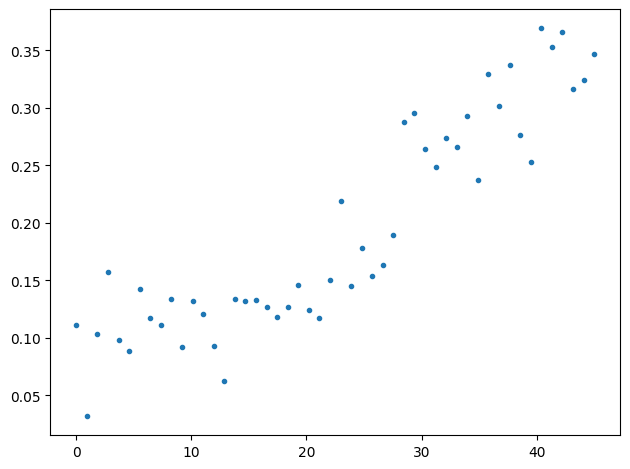

In [15]:
plt.plot(Angles , Error, ".")

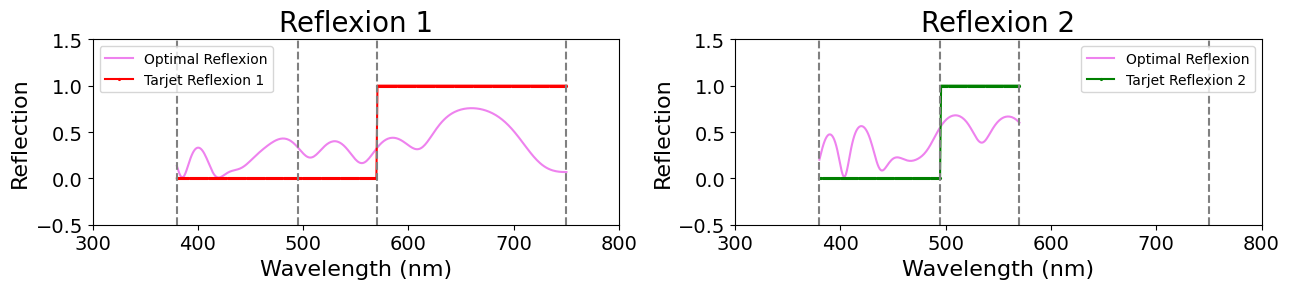

Espesores: tensor([0.0992, 0.1104, 0.1289, 0.1207, 0.0979, 0.0833, 0.0679, 0.1032, 0.0754,
        0.0453, 0.0440, 0.0413, 0.0835, 0.0592, 0.0855, 0.0350, 0.0551, 0.0564,
        0.0649, 0.1078, 0.1238, 0.0888, 0.0673, 0.0722, 0.0759])
Índices de refracción: tensor([2.2943, 2.3951, 1.4694, 1.7354, 1.9702, 1.7653, 1.2873, 1.6529, 2.5393,
        1.9702, 1.6287, 1.2645, 2.2054, 1.2418, 1.1128, 1.5714, 2.2358, 1.0900,
        2.0349, 2.4710, 1.5908, 1.4522, 1.1811, 1.4315, 2.2359],
       dtype=torch.float64)


In [ ]:
# Definir xlim, ylim y vertical_lines
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

# Subplots para Reflexiones (solo 2)
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)

# Definir optimal_reflections
optimal_reflections = {}

for i in range(1, 3):  # Solo 1 y 2
    reflex_key = f'reflexion_{i}'
    optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
    
    # Gráfico de reflexión óptima
    axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                  optimal_reflections[f'reflexion_{i}'][:, 0, 0].detach().numpy(),
                  "-", color="violet", label="Optimal Reflexion")

    # Gráfico de reflexión de tarjeta
    tarjet_color = "red" if i == 1 else "green"
    axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                  tarjet.tarjets[f"tarjet_{i}"].view(-1),
                  ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)

    axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
    axs[i-1].set_ylabel("Reflection", fontsize=16)
    axs[i-1].legend(fontsize=10)
    axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
    axs[i-1].tick_params(axis='both', which='major', labelsize=14)
    axs[i-1].set_xlim(xlim)
    axs[i-1].set_ylim(ylim)

    # Agregar líneas verticales punteadas para reflexiones
    for line_pos in vertical_lines:
        axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de reflexiones
plt.show()

print("Espesores:", optimal_thicknesses.view(-1))
print("Índices de refracción:", optimal_ref_idx.view(-1))


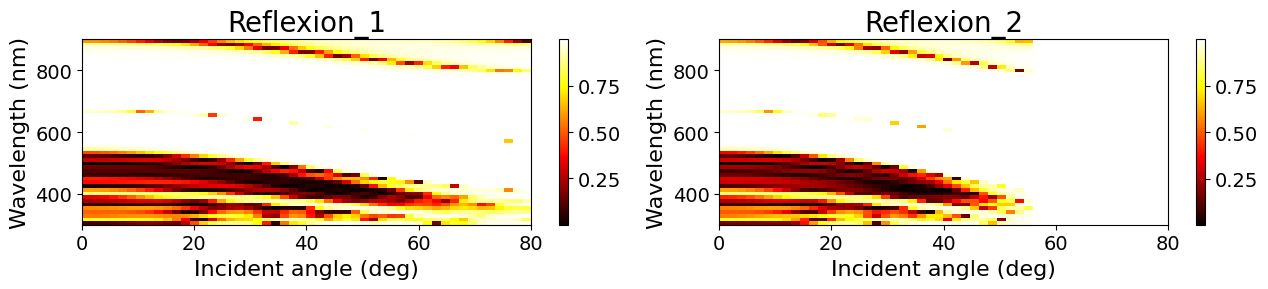

In [ ]:
(thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector=params.k_test, inc_angles=params.theta_test, grayscale=True)
r = []
params.k_test = 2 * math.pi / torch.linspace(0.3, 0.9, 50)
params.theta_test = torch.linspace(0, math.pi/2.25, 50)

for i in range(2):  # Solo 2 iteraciones para reflexion_1 y reflexion_2
    r_  = TMM_solver(thicknesses, 
                        ref_index, 
                        getattr(physicsparams, f'n_top_{i + 1}'), 
                        getattr(physicsparams, f'n_bot_{i + 1}'),
                        params.k_test,
                        params.theta_test)
    r.append(r_)

_ ,  index = torch.sort(FoM_reflex_total)
opt_inx =  index[0]

# Gráficos para Reflexiones (solo 2)
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)
for i in range(2):  # Solo 2 gráficos para reflexion_1 y reflexion_2
    im1 = axs[i].imshow(r[i][opt_inx, : , 0, :].detach().cpu().numpy(), origin='lower', aspect='auto', cmap='hot', extent=[0, 80, 300, 900])
    cbar1 = fig.colorbar(im1, ax=axs[i])
    cbar1.ax.tick_params(labelsize=14)
    axs[i].set_title(f'Reflexion_{i + 1}', fontsize=20)  # Reflexion_{1} y Reflexion_{2}
    axs[i].set_xlabel('Incident angle (deg)', fontsize=16)
    axs[i].set_ylabel('Wavelength (nm)', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

plt.show()
